In [2]:
# import packages
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import foldnorm
from uncertainty_toolbox import metrics_calibration


# fix numpy seed for reproducibility


### Generates the toy model

In [3]:
import torch

def NLL(input: torch.Tensor, target: torch.Tensor, var: torch.Tensor, full=True, eps=1e-06):
    return torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), var.flatten(), full=full,eps=eps)

def RMSE(input, target):
    return torch.sqrt(torch.mean((input.flatten() - target.flatten())**2))

def MSE(input, target):
    return torch.mean((input.flatten() - target.flatten())**2)

def get_coeff(input: torch.Tensor, target: torch.Tensor, var: torch.Tensor) -> torch.tensor:
    """ Returns dimensionless NLL coefficient
    """
    #print(input.shape)
    #print(target.shape)
    #print(var.shape)
    
    mse = MSE(input,target)
    uncertainty_estimate = (input.flatten() - target.flatten())**2
    
    LL_best = torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), uncertainty_estimate.flatten(), full=False, eps=0.)
    
    LL_worst_case_best_RMSE = torch.nn.functional.gaussian_nll_loss\
        (input.flatten(), target.flatten(), torch.ones_like(var.flatten())*mse, full=False, eps=0.)
    
    LL_actual = torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), var.flatten(), full=False, eps=0.)
    
    coeff = 1/( LL_best - LL_worst_case_best_RMSE) * (LL_actual - LL_worst_case_best_RMSE) * 100

    return coeff

In [4]:
def get_z_score_variance(input: torch.tensor, target: torch.tensor, var_pred: torch.tensor):

    z = (target.flatten() - input.flatten()) / torch.sqrt(var_pred.flatten())

    return torch.var(z)

In [5]:
import matplotlib.pyplot as plt
import matplotlib

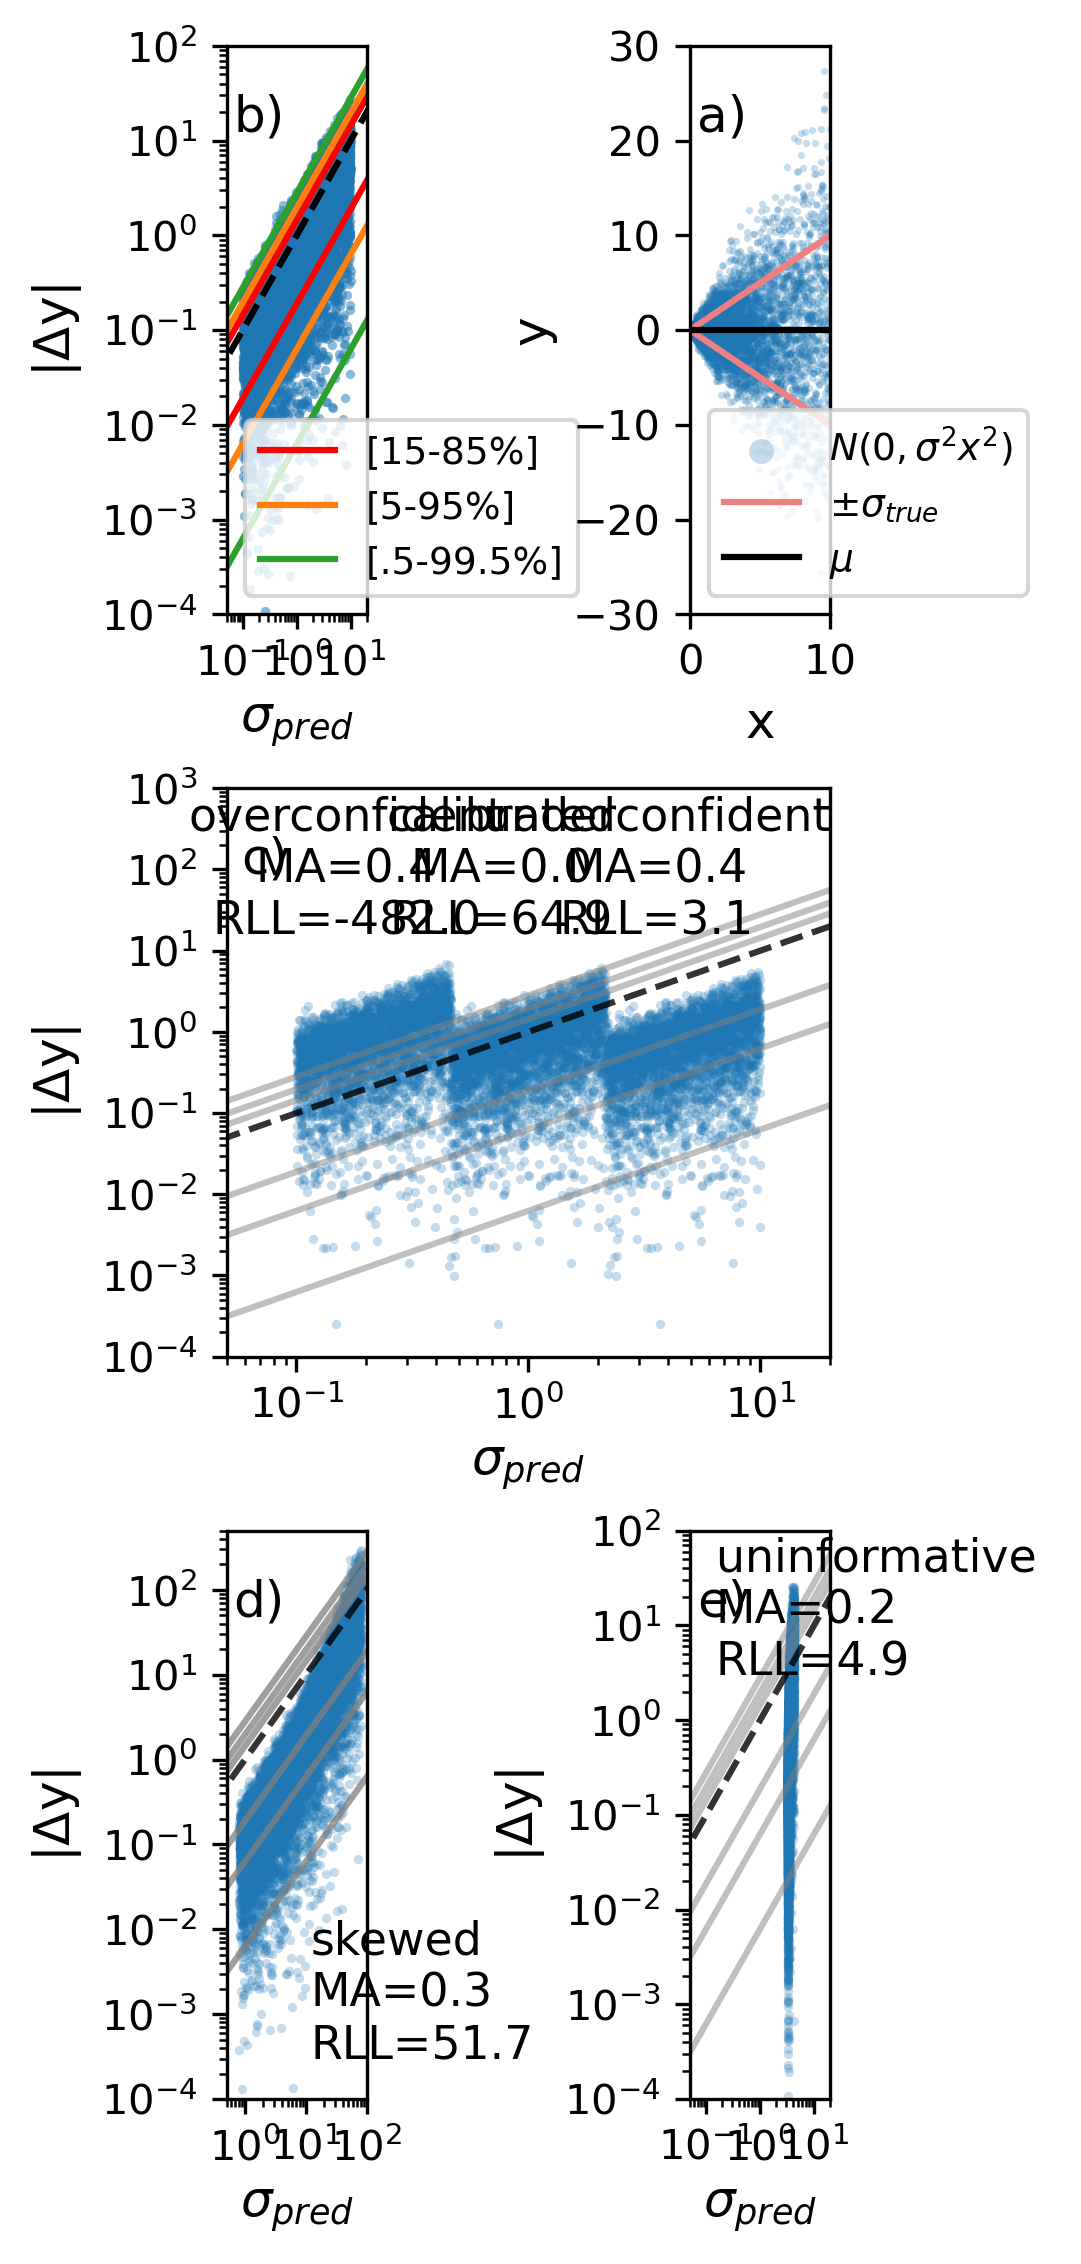

In [5]:
ROUND_DIGITS = 1
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=10.0) 
matplotlib.rc('ytick', labelsize=10.0) 
plt.rc('axes', labelsize=12.)

QUANTILE_ALPHA = 0.5
QUANTILE_ALPHA_UNIT = 0.8
SCATTER_ALPHA = 0.25

POINTS =10000
np.random.seed(0)

#generate the grid points
x = np.logspace(-1.,1,POINTS)
y = np.zeros(POINTS)

#generate the noise/targets
#noise level is the perfect uncertainty estimate 

noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 

#generate residuals
z = np.abs(y-(y+noise_hetero))



#generate the quantile lines by evaluating the folded normal distribution
# quantile distribution

x_2 = np.logspace(-5.,5.,10)
noise_level_2 = np.abs(x_2)
quantiles_lower_01 = [foldnorm.ppf(0.15, 0.,0.,i) for i in noise_level_2]
quantiles_upper_01 = [foldnorm.ppf(0.85, 0.,0.,i) for i in noise_level_2]
quantiles_lower_05 = [foldnorm.ppf(0.05, 0.,0.,i) for i in noise_level_2]
quantiles_upper_05 = [foldnorm.ppf(0.95, 0.,0.,i) for i in noise_level_2]
quantiles_lower_005 = [foldnorm.ppf(0.005, 0.,0.,i) for i in noise_level_2]
quantiles_upper_005 = [foldnorm.ppf(0.995, 0.,0.,i) for i in noise_level_2]

fig = plt.figure(figsize=(9.0, 7.5), dpi=300)
spec = fig.add_gridspec(3, 6)


ax0 = fig.add_subplot(spec[1, :2])
ax10 = fig.add_subplot(spec[2, 0])
ax11 = fig.add_subplot(spec[2, 1])

axexplain  = fig.add_subplot(spec[0, 0])
axtoy = fig.add_subplot(spec[0, 1])

axtoy.scatter(x,y+noise_hetero,s=3., alpha=SCATTER_ALPHA, rasterized=True, linewidth=0. )
axtoy.scatter([],[],label=r"$N(0,\sigma^2 x^2)$", alpha=SCATTER_ALPHA, linewidth=0., color="tab:blue" )
axtoy.plot(x,y+noise_level, color="lightcoral", label=r"$\pm \sigma_{true}$", rasterized=True)
#plt.plot(x,y+1/alpha*noise_level, color="tab:red", label=r"$\sigma_{pred}$")
axtoy.plot(x,y-noise_level, color="lightcoral", rasterized=True)
#plt.plot(x,y-1/alpha*noise_level, color="tab:red",)
axtoy.axhline(0,  color="black", label=r"$\mu$", rasterized=True)
axtoy.text(0.05, 0.85, "a)", fontsize=12, transform=axtoy.transAxes, rasterized=True)
axtoy.legend(loc="lower left",fontsize=9.)
axtoy.set_ylim(-30,30)
axtoy.set_xlim(0,10)
axtoy.set_xlabel("x")
axtoy.set_ylabel("y")









axexplain.scatter(noise_level, z, s=5., color="tab:blue", alpha=0.5, rasterized=True, linewidth=0.)

axexplain.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", rasterized=True)


axexplain.loglog()
axexplain.set_xlim(0.05,20)
axexplain.set_ylim(1e-04,1e02)
axexplain.set_ylabel(r"|$\Delta$y|")
axexplain.set_xlabel(r"$\sigma_{pred}$")
axexplain.legend(fontsize=9.)
axexplain.text(0.05, 0.85, "b)", fontsize=12, transform=axexplain.transAxes, rasterized=True)





for a_i, interval, title in zip([5.,1,1/5.,], [(10**(1/3),10**1), (10**-(1/3),10**(1/3)), (10**-1, 10**-(1/3)),],["underconfident","calibrated","overconfident"]):
    tmp_noise = np.copy(noise_level)*a_i
    #only plot point within the range 1e-1 and 1e-2/3
    tmp_noise_sel = (tmp_noise > interval[0]) & (tmp_noise < interval[1])
    
    if a_i != 1:
        ax0.scatter(tmp_noise[tmp_noise_sel], z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    else:
        ax0.scatter(tmp_noise[tmp_noise_sel] , z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    
    #text in the upper left corner with miscalibration area
    
    MA = metrics_calibration.miscalibration_area(y, noise_level*a_i,(y+noise_hetero))
    
    SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(tmp_noise)**2)

    

    ax0.text(interval[0]*1.65, 100, title + "\n" + \
             f"MA={round(MA,ndigits=ROUND_DIGITS)}"\
             + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}",\
            
            horizontalalignment='center',
            verticalalignment='center',)

    #print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y),\
    #                torch.tensor(y+noise_hetero),\
    #                torch.tensor(tmp_noise)**2)))
    # + "\n" +f"sharpness={round(sharpness,ndigits=3)}",\

ax0.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)
ax0.loglog()

ax0.set_xlim(0.05,20)
ax0.set_ylim(1e-04,1e03)

ax0.set_ylabel(r"|$\Delta$y|")
ax0.set_xlabel(r"$\sigma_{pred}$")
ax0.text(0.025, 0.85, "c)", fontsize=12, transform=ax0.transAxes, rasterized=True)


# now make skewed plots (bia changing the noise level):
alpha=0.5

#introduce weights such that the

noise_level_skewed = np.abs(x) ** (2) + np.abs(x)
noise_hetero_skewed = np.random.normal(y,noise_level_skewed,POINTS) 

z_skewed = np.abs(y-(y+noise_hetero_skewed))
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.scatter(noise_level*alpha_cal, z_skewed, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
ax10.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,1000)
ax10.set_ylim(1e-04,5e02)

MA = metrics_calibration.miscalibration_area(y, noise_level*alpha_cal,(y+noise_hetero_skewed))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero_skewed),\
                    torch.tensor(noise_level*alpha_cal)**2)

#print("mean error:",np.mean(z_skewed**2/(noise_level*alpha_cal)**2))
#print("mean: {}".format(np.mean(z_skewed**2)))
#print("mean var: {}".format(np.mean(noise_level**2)))
#print("mean var cal: {}".format(np.mean((noise_level*alpha_cal)**2)))

#print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y+noise_hetero_skewed),\
#                    torch.tensor(y),\
#                    torch.tensor(noise_level*alpha_cal)**2)))

ax10.text(12
          , 3e-4, "skewed" + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

#get rmse

ax10.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,100)
ax10.set_ylim(1e-04,5e02)
ax10.set_ylabel(r"|$\Delta$y|")
ax10.set_xlabel(r"$\sigma_{pred}$")
ax10.text(0.05, 0.85, "d)", fontsize=12, transform=ax10.transAxes, rasterized=True)




noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 
z = np.abs(y-(y+noise_hetero))

rmse = float(RMSE(torch.tensor(y+noise_hetero),torch.tensor(y)))

uniformative_uq = rmse*np.ones_like(noise_level) + np.abs(x) * 0.1

ax11.scatter(uniformative_uq, z, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
MA = metrics_calibration.miscalibration_area(y, uniformative_uq,(y+noise_hetero))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(uniformative_uq)**2)

ax11.text(.15, 3., "uninformative " + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

ax11.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)


ax11.loglog()
ax11.set_xlim(0.05,20)
ax11.set_ylim(1e-04,1e02)
ax11.set_ylabel(r"|$\Delta$y|")
ax11.set_xlabel(r"$\sigma_{pred}$")
ax11.text(0.05, 0.85, "e)", fontsize=12, transform=ax11.transAxes, rasterized=True)



plt.tight_layout(pad=0.50)
plt.show()

fig.savefig("compound_toy_plot_transposed.pdf",dpi=300, bbox_inches='tight')

In [8]:
import scipy as sp

<Figure size 2700x2250 with 0 Axes>

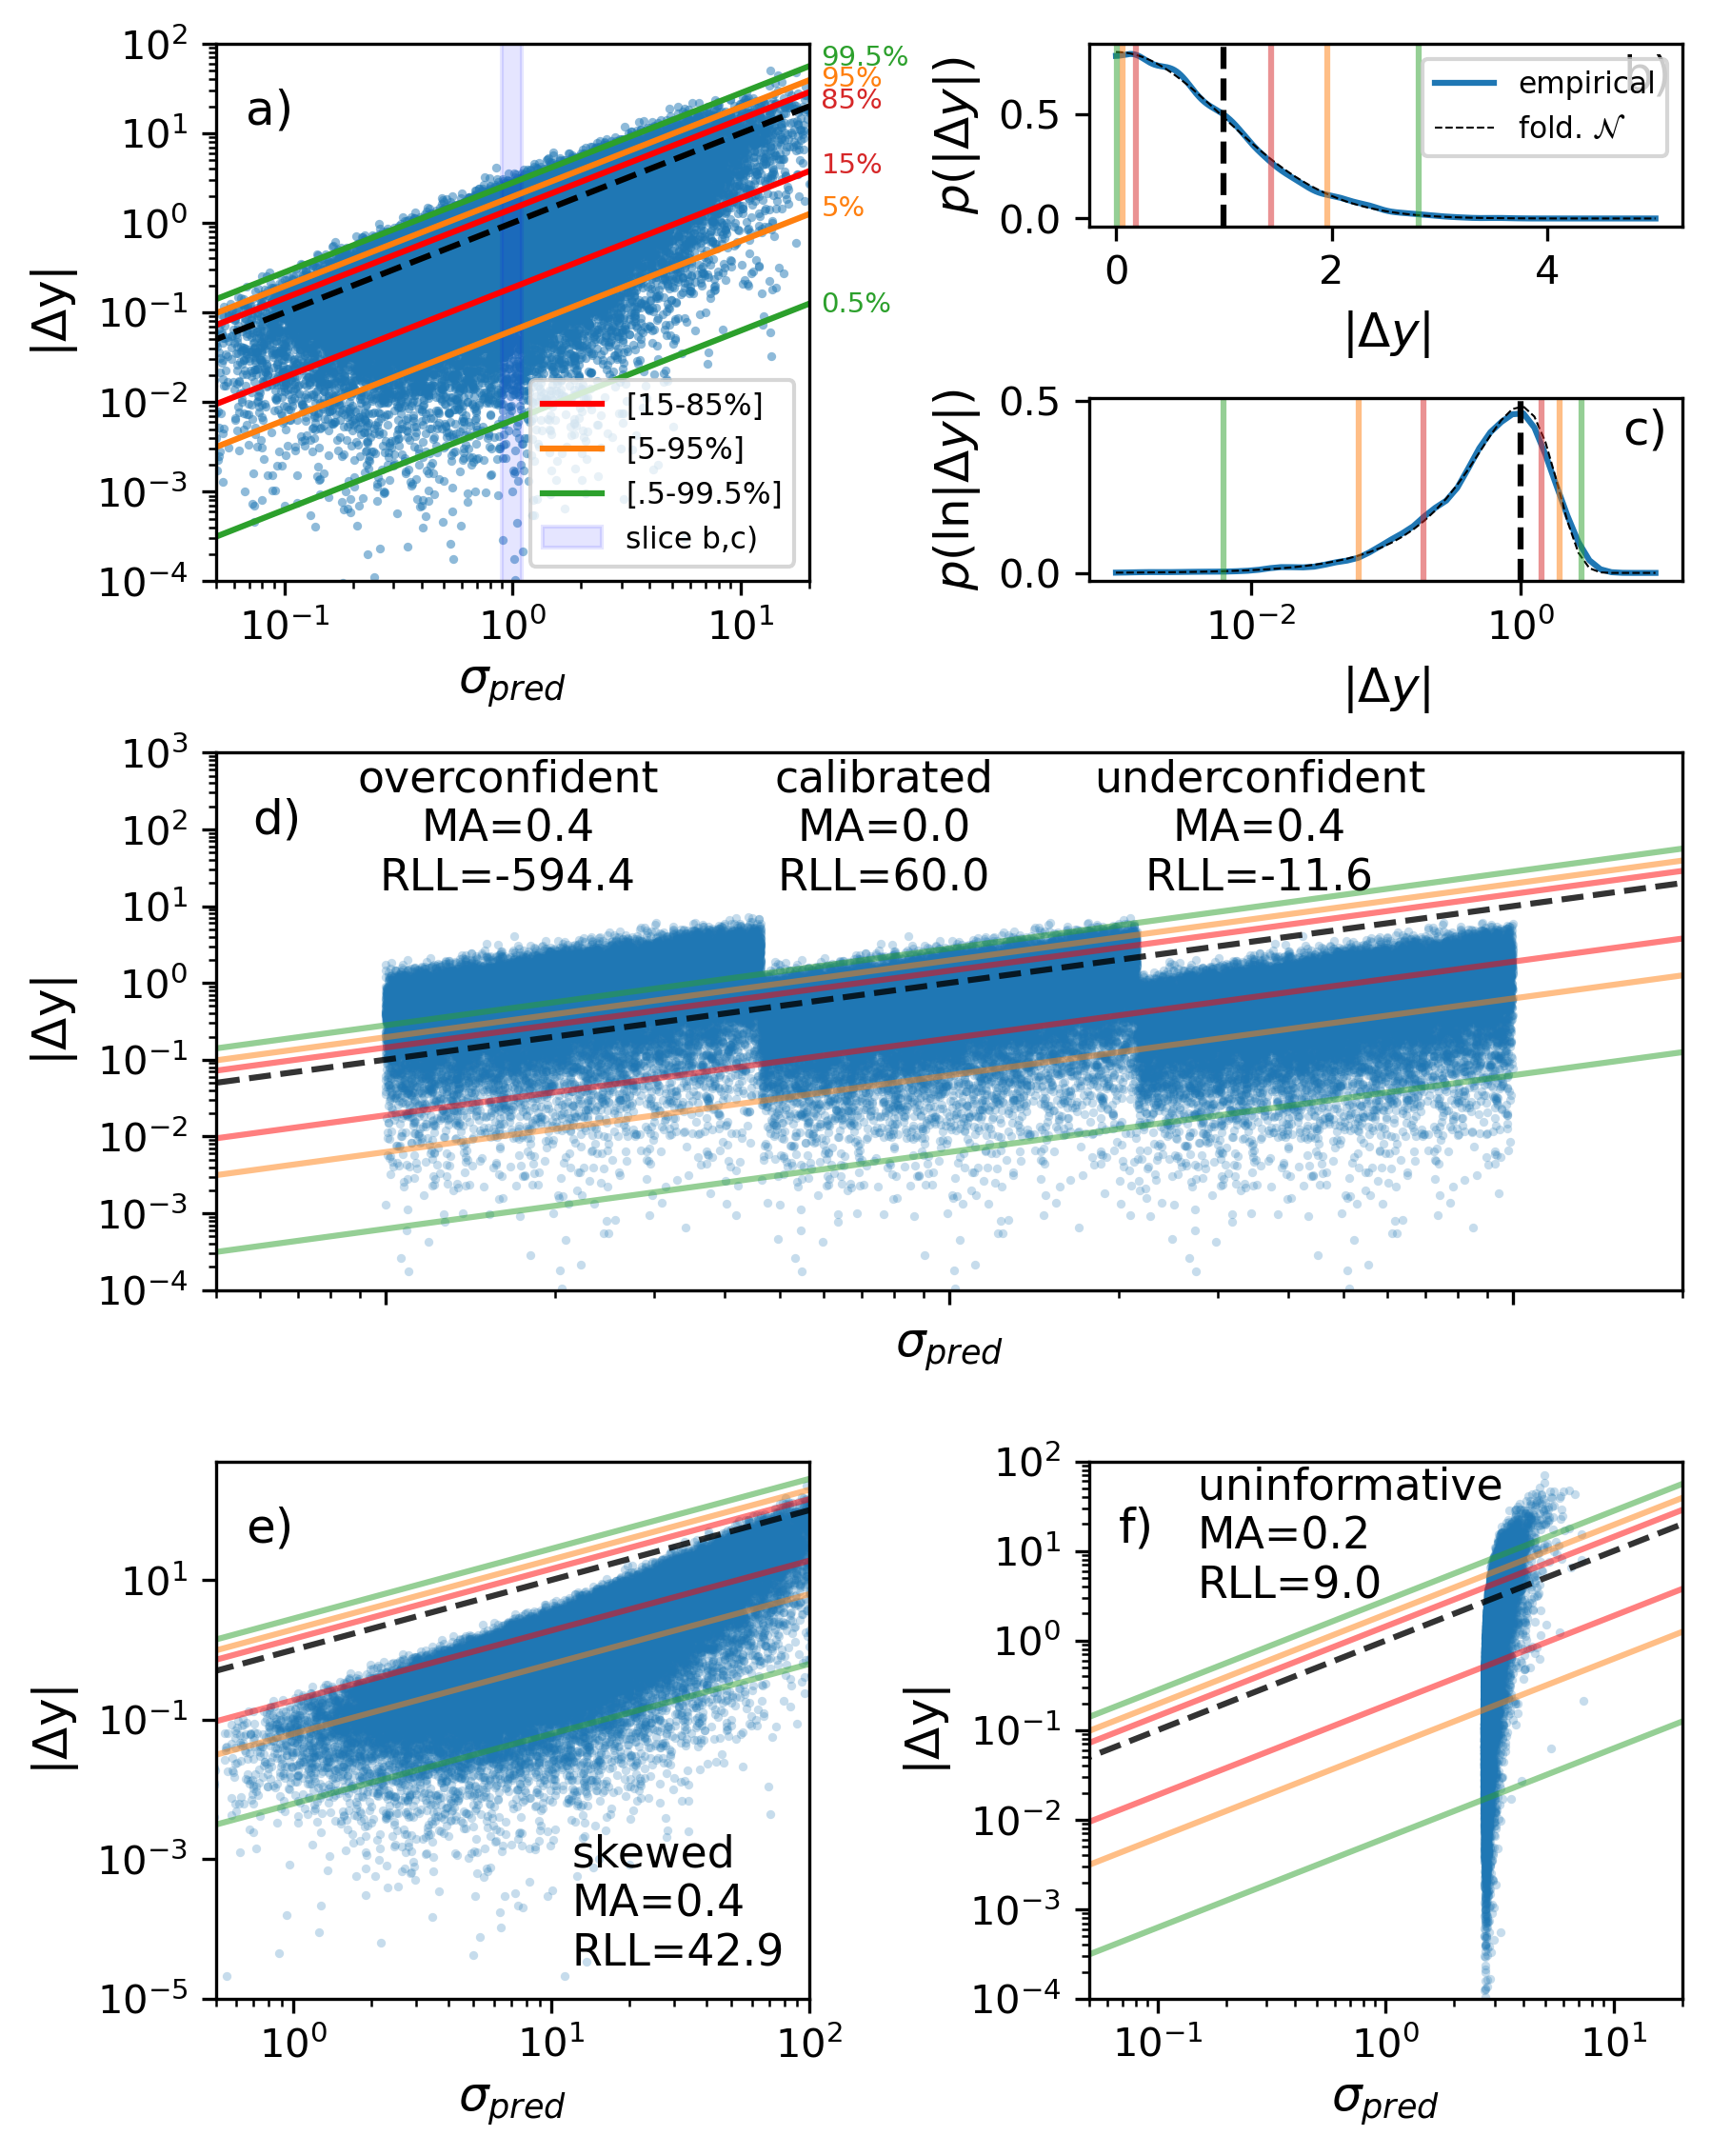

In [9]:
ROUND_DIGITS = 1
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=10.0) 
matplotlib.rc('ytick', labelsize=10.0) 
plt.rc('axes', labelsize=12.)

QUANTILE_ALPHA = 0.5
QUANTILE_ALPHA_UNIT = 0.8
SCATTER_ALPHA = 0.25

POINTS = 50000
np.random.seed(0)

#generate the grid points
#x = np.logspace(-1.,1,POINTS)

x = np.random.lognormal(mean=0.0, sigma=1.0, size=50000)
y = np.zeros(POINTS)

#generate the noise/targets
#noise level is the perfect uncertainty estimate 
fig = plt.figure(figsize=(9.0, 7.5), dpi=300)
noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 

#generate residuals
z = np.abs(y-(y+noise_hetero))


spec = fig.add_gridspec(6, 3)

#generate the quantile lines by evaluating the folded normal distribution
# quantile distribution


x_2 = np.logspace(-5.,5.,10)
noise_level_2 = np.abs(x_2)
quantiles_lower_01 = [foldnorm.ppf(0.15, 0.,0.,i) for i in noise_level_2]
quantiles_upper_01 = [foldnorm.ppf(0.85, 0.,0.,i) for i in noise_level_2]
quantiles_lower_05 = [foldnorm.ppf(0.05, 0.,0.,i) for i in noise_level_2]
quantiles_upper_05 = [foldnorm.ppf(0.95, 0.,0.,i) for i in noise_level_2]
quantiles_lower_005 = [foldnorm.ppf(0.005, 0.,0.,i) for i in noise_level_2]
quantiles_upper_005 = [foldnorm.ppf(0.995, 0.,0.,i) for i in noise_level_2]

fig = plt.figure(figsize=(9.0, 7.5), dpi=300)
spec = fig.add_gridspec(6, 3)


ax0 = fig.add_subplot(spec[2:4, :2])
ax10 = fig.add_subplot(spec[4:6, 0])
ax11 = fig.add_subplot(spec[4:6, 1])

axexplain  = fig.add_subplot(spec[:2, 0])
axtoy = fig.add_subplot(spec[0, 1])
axtoy2 = fig.add_subplot(spec[1, 1])
ax0.tick_params(labelbottom=False)

axexplain.scatter(noise_level, z, s=5., color="tab:blue", alpha=0.5, rasterized=True, linewidth=0.)

axexplain.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", rasterized=True)

max_slice = 1.1
min_slice = 0.9

axexplain.text(1.02, 0.96, "99.5%", color="tab:green", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.92, "95%", color="tab:orange", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.88, "85%", color="tab:red", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.76, "15%", color="tab:red", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.68, "5%", color="tab:orange", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.5, "0.5%", color="tab:green", fontsize=7, transform=axexplain.transAxes, rasterized=True)

ymin, ymax = axexplain.get_ylim()
axexplain.fill_betweenx([ymin, ymax], min_slice, max_slice, color='b', alpha=0.1, label="slice b,c)")



real_z = z[(noise_level > min_slice) & (noise_level < max_slice)]

kd = sp.stats.gaussian_kde(real_z)
dy = np.linspace(0,5,1000)

#axtoy.hist(real_z, bins=30, color="tab:blue", alpha=0.5, label="slice for b)")
axtoy.plot(dy, (kd(dy)+kd(-dy)), 'tab:blue', label="empirical")
axtoy.plot(dy, 2*np.exp(-dy**2/2)/np.sqrt(2*np.pi), 
              'k--', lw=0.5, label=r"fold. $\mathcal{N}$")

axtoy.axvline(1, color="black", linestyle="--", rasterized=True)
axtoy.axvline(sp.special.erfinv(0.15)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.85)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.05)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.95)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.005)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.995)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)

axtoy.legend(fontsize=7.5)

lkd = sp.stats.gaussian_kde(np.log(real_z))
dy = np.geomspace(1e-3,10)
ldy = np.log(dy)
axtoy2.semilogx(dy, lkd(ldy), 'tab:blue')
axtoy2.plot(dy, 2*dy*np.exp(-dy**2/2)/np.sqrt(2*np.pi), 
              'k--', lw=0.5)

quantile_vals = sp.special.erfinv([0.005,0.05,0.15,0.5,0.85,0.95,0.995])*np.sqrt(2)

axtoy2.axvline(1, color="black", linestyle="--", rasterized=True)
axtoy2.axvline(sp.special.erfinv(0.15)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.85)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.05)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.95)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.005)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.995)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)

axtoy.set_ylabel(r"$p(|\Delta y|)$")
axtoy.set_xlabel(r"$|\Delta y|$")
axtoy2.set_xlabel(r"$|\Delta y|$")
axtoy2.set_ylabel(r"$p(\ln|\Delta y|)$")      

axtoy.text(0.9, 0.75, "b)", fontsize=12, transform=axtoy.transAxes, rasterized=True)
axtoy2.text(0.9, 0.75, "c)", fontsize=12, transform=axtoy2.transAxes, rasterized=True)

axexplain.loglog()
axexplain.set_xlim(0.05,20)
axexplain.set_ylim(1e-04,1e02)
axexplain.set_ylabel(r"|$\Delta$y|")
axexplain.set_xlabel(r"$\sigma_{pred}$")
axexplain.legend(fontsize=7.5)
axexplain.text(0.05, 0.85, "a)", fontsize=12, transform=axexplain.transAxes, rasterized=True)







    #print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y),\
    #                torch.tensor(y+noise_hetero),\
    #                torch.tensor(tmp_noise)**2)))
    # + "\n" +f"sharpness={round(sharpness,ndigits=3)}",\


ax0.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)
ax0.loglog()

ax0.set_xlim(0.05,20)
ax0.set_ylim(1e-04,1e03)

ax0.set_ylabel(r"|$\Delta$y|")
ax0.set_xlabel(r"$\sigma_{pred}$")
ax0.text(0.025, 0.85, "d)", fontsize=12, transform=ax0.transAxes, rasterized=True)

for a_i, interval, title in zip([5.,1,1/5.,], [(10**(1/3),10**1), (10**-(1/3),10**(1/3)), (10**-1, 10**-(1/3)),],["underconfident","calibrated","overconfident"]):
    tmp_noise = np.copy(noise_level)*a_i
    #only plot point within the range 1e-1 and 1e-2/3
    tmp_noise_sel = (tmp_noise > interval[0]) & (tmp_noise < interval[1])
    
    if a_i != 1:
        ax0.scatter(tmp_noise[tmp_noise_sel], z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    else:
        ax0.scatter(tmp_noise[tmp_noise_sel] , z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    
    #text in the upper left corner with miscalibration area
    
    MA = metrics_calibration.miscalibration_area(y, noise_level*a_i,(y+noise_hetero))
    
    SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(tmp_noise)**2)

    

    ax0.text(interval[0]*1.65, 100, title + "\n" + \
             f"MA={round(MA,ndigits=ROUND_DIGITS)}"\
             + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}",\
            
            horizontalalignment='center',
            verticalalignment='center',)

# now make skewed plots (bia changing the noise level):
alpha=0.5

#introduce weights such that the

noise_level_skewed = np.abs(x) ** (2) + np.abs(x)
noise_hetero_skewed = np.random.normal(y,noise_level_skewed,POINTS) 

z_skewed = np.abs(y-(y+noise_hetero_skewed))
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.scatter(noise_level*alpha_cal, z_skewed, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,1000)
ax10.set_ylim(1e-04,5e02)

MA = metrics_calibration.miscalibration_area(y, noise_level*alpha_cal,(y+noise_hetero_skewed))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero_skewed),\
                    torch.tensor(noise_level*alpha_cal)**2)

#print("mean error:",np.mean(z_skewed**2/(noise_level*alpha_cal)**2))
#print("mean: {}".format(np.mean(z_skewed**2)))
#print("mean var: {}".format(np.mean(noise_level**2)))
#print("mean var cal: {}".format(np.mean((noise_level*alpha_cal)**2)))

#print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y+noise_hetero_skewed),\
#                    torch.tensor(y),\
#                    torch.tensor(noise_level*alpha_cal)**2)))

ax10.text(12
          , 3e-5, "skewed" + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

#get rmse



ax10.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,100)
ax10.set_ylim(1e-05,5e02)
ax10.set_ylabel(r"|$\Delta$y|")
ax10.set_xlabel(r"$\sigma_{pred}$")
ax10.text(0.05, 0.85, "e)", fontsize=12, transform=ax10.transAxes, rasterized=True)




noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 
z = np.abs(y-(y+noise_hetero))

rmse = float(RMSE(torch.tensor(y+noise_hetero),torch.tensor(y)))

uniformative_uq = rmse*np.ones_like(noise_level) + np.abs(x) * 0.1

ax11.scatter(uniformative_uq, z, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
MA = metrics_calibration.miscalibration_area(y, uniformative_uq,(y+noise_hetero))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(uniformative_uq)**2)

ax11.text(.15, 3., "uninformative " + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

ax11.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)


ax11.loglog()
ax11.set_xlim(0.05,20)
ax11.set_ylim(1e-04,1e02)
ax11.set_ylabel(r"|$\Delta$y|")
ax11.set_xlabel(r"$\sigma_{pred}$")
ax11.text(0.05, 0.85, "f)", fontsize=12, transform=ax11.transAxes, rasterized=True)




plt.tight_layout(pad=0.5)
plt.show()

fig.savefig("compound_toy_plot_transposed.pdf",dpi=300, bbox_inches='tight')

<Figure size 2700x2250 with 0 Axes>

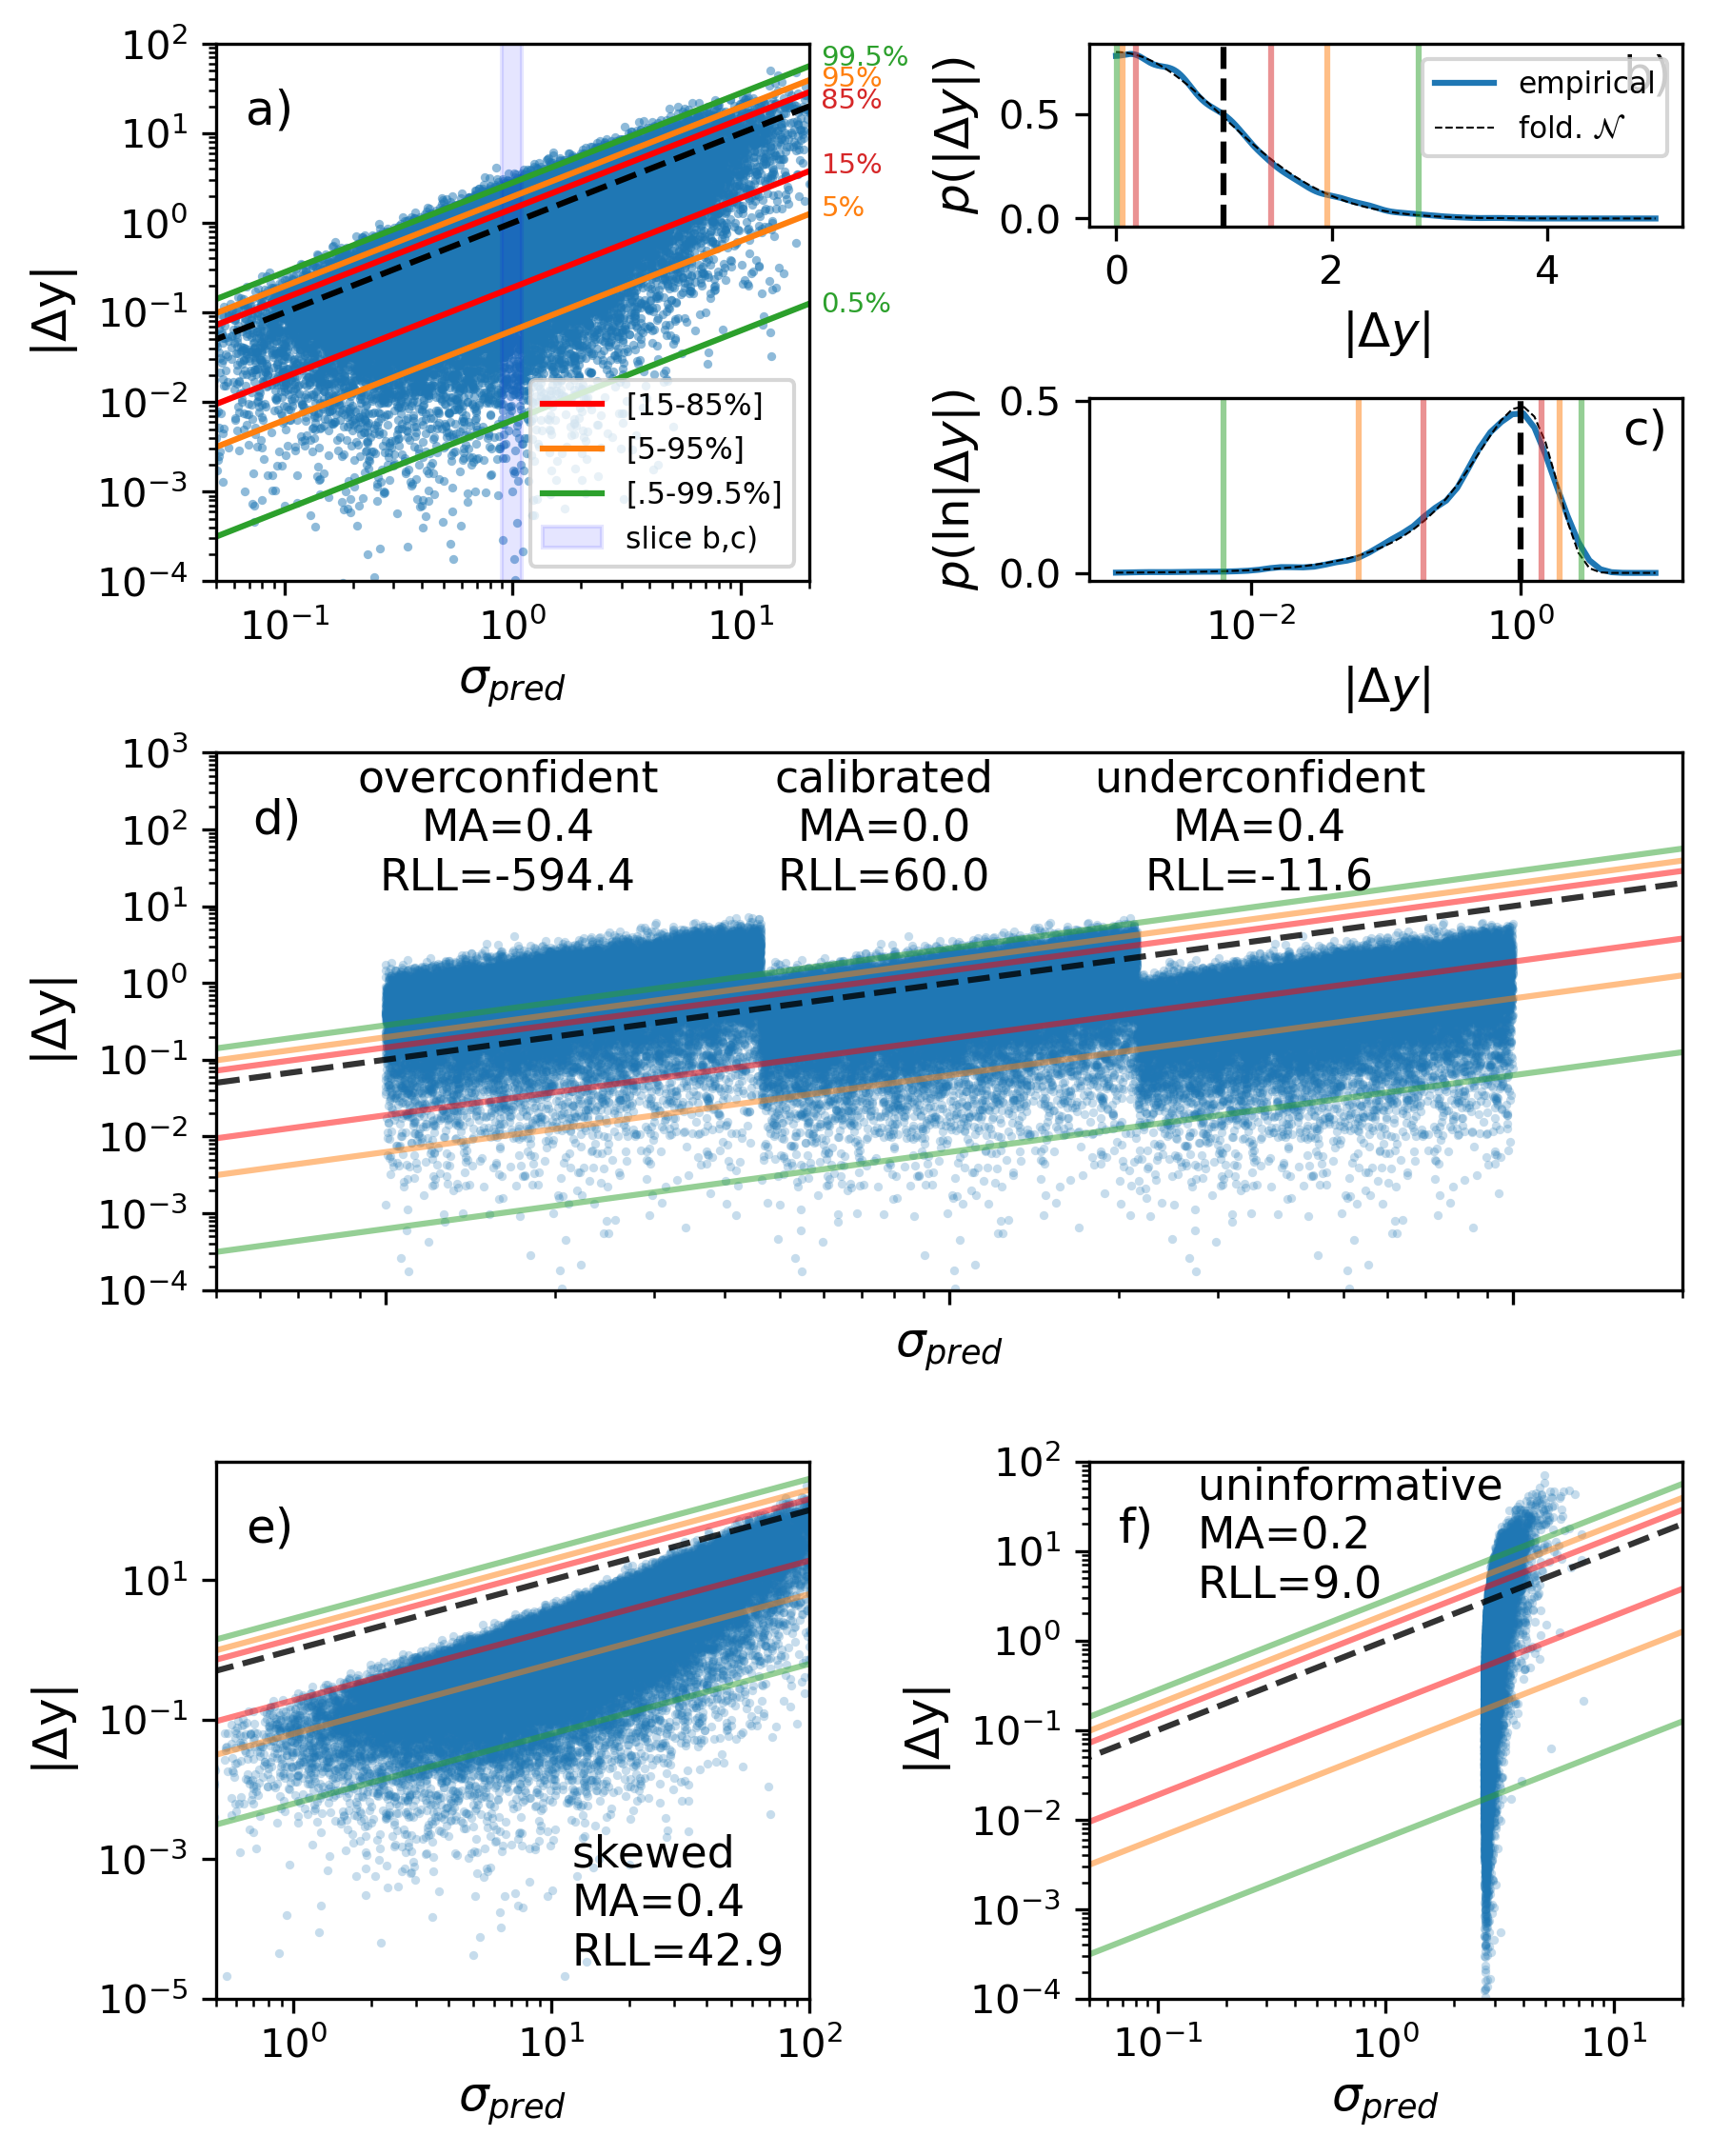

In [10]:
ROUND_DIGITS = 1
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=10.0) 
matplotlib.rc('ytick', labelsize=10.0) 
plt.rc('axes', labelsize=12.)

QUANTILE_ALPHA = 0.5
QUANTILE_ALPHA_UNIT = 0.8
SCATTER_ALPHA = 0.25

POINTS = 50000
np.random.seed(0)

#generate the grid points
#x = np.logspace(-1.,1,POINTS)

x = np.random.lognormal(mean=0.0, sigma=1.0, size=50000)
y = np.zeros(POINTS)

#generate the noise/targets
#noise level is the perfect uncertainty estimate 
fig = plt.figure(figsize=(9.0, 7.5), dpi=300)
noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 

#generate residuals
z = np.abs(y-(y+noise_hetero))


spec = fig.add_gridspec(6, 3)

#generate the quantile lines by evaluating the folded normal distribution
# quantile distribution


x_2 = np.logspace(-5.,5.,10)
noise_level_2 = np.abs(x_2)
quantiles_lower_01 = [foldnorm.ppf(0.15, 0.,0.,i) for i in noise_level_2]
quantiles_upper_01 = [foldnorm.ppf(0.85, 0.,0.,i) for i in noise_level_2]
quantiles_lower_05 = [foldnorm.ppf(0.05, 0.,0.,i) for i in noise_level_2]
quantiles_upper_05 = [foldnorm.ppf(0.95, 0.,0.,i) for i in noise_level_2]
quantiles_lower_005 = [foldnorm.ppf(0.005, 0.,0.,i) for i in noise_level_2]
quantiles_upper_005 = [foldnorm.ppf(0.995, 0.,0.,i) for i in noise_level_2]

fig = plt.figure(figsize=(9.0, 7.5), dpi=300)
spec = fig.add_gridspec(6, 3)


ax0 = fig.add_subplot(spec[2:4, :2])
ax10 = fig.add_subplot(spec[4:6, 0])
ax11 = fig.add_subplot(spec[4:6, 1])

axexplain  = fig.add_subplot(spec[:2, 0])
axtoy = fig.add_subplot(spec[0, 1])
axtoy2 = fig.add_subplot(spec[1, 1])
ax0.tick_params(labelbottom=False)

axexplain.scatter(noise_level, z, s=5., color="tab:blue", alpha=0.5, rasterized=True, linewidth=0.)

axexplain.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", rasterized=True)

max_slice = 1.1
min_slice = 0.9

axexplain.text(1.02, 0.96, "99.5%", color="tab:green", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.92, "95%", color="tab:orange", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.88, "85%", color="tab:red", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.76, "15%", color="tab:red", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.68, "5%", color="tab:orange", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.5, "0.5%", color="tab:green", fontsize=7, transform=axexplain.transAxes, rasterized=True)

ymin, ymax = axexplain.get_ylim()
axexplain.fill_betweenx([ymin, ymax], min_slice, max_slice, color='b', alpha=0.1, label="slice b,c)")



real_z = z[(noise_level > min_slice) & (noise_level < max_slice)]

kd = sp.stats.gaussian_kde(real_z)
dy = np.linspace(0,5,1000)

#axtoy.hist(real_z, bins=30, color="tab:blue", alpha=0.5, label="slice for b)")
axtoy.plot(dy, (kd(dy)+kd(-dy)), 'tab:blue', label="empirical")
axtoy.plot(dy, 2*np.exp(-dy**2/2)/np.sqrt(2*np.pi), 
              'k--', lw=0.5, label=r"fold. $\mathcal{N}$")

axtoy.axvline(1, color="black", linestyle="--", rasterized=True)
axtoy.axvline(sp.special.erfinv(0.15)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.85)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.05)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.95)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.005)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.995)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)

axtoy.legend(fontsize=7.5)

lkd = sp.stats.gaussian_kde(np.log(real_z))
dy = np.geomspace(1e-3,10)
ldy = np.log(dy)
axtoy2.semilogx(dy, lkd(ldy), 'tab:blue')
axtoy2.plot(dy, 2*dy*np.exp(-dy**2/2)/np.sqrt(2*np.pi), 
              'k--', lw=0.5)

quantile_vals = sp.special.erfinv([0.005,0.05,0.15,0.5,0.85,0.95,0.995])*np.sqrt(2)

axtoy2.axvline(1, color="black", linestyle="--", rasterized=True)
axtoy2.axvline(sp.special.erfinv(0.15)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.85)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.05)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.95)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.005)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.995)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)

axtoy.set_ylabel(r"$p(|\Delta y|)$")
axtoy.set_xlabel(r"$|\Delta y|$")
axtoy2.set_xlabel(r"$|\Delta y|$")
axtoy2.set_ylabel(r"$p(\ln|\Delta y|)$")      

axtoy.text(0.9, 0.75, "b)", fontsize=12, transform=axtoy.transAxes, rasterized=True)
axtoy2.text(0.9, 0.75, "c)", fontsize=12, transform=axtoy2.transAxes, rasterized=True)

axexplain.loglog()
axexplain.set_xlim(0.05,20)
axexplain.set_ylim(1e-04,1e02)
axexplain.set_ylabel(r"|$\Delta$y|")
axexplain.set_xlabel(r"$\sigma_{pred}$")
axexplain.legend(fontsize=7.5)
axexplain.text(0.05, 0.85, "a)", fontsize=12, transform=axexplain.transAxes, rasterized=True)







    #print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y),\
    #                torch.tensor(y+noise_hetero),\
    #                torch.tensor(tmp_noise)**2)))
    # + "\n" +f"sharpness={round(sharpness,ndigits=3)}",\


ax0.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)
ax0.loglog()

ax0.set_xlim(0.05,20)
ax0.set_ylim(1e-04,1e03)

ax0.set_ylabel(r"|$\Delta$y|")
ax0.set_xlabel(r"$\sigma_{pred}$")
ax0.text(0.025, 0.85, "d)", fontsize=12, transform=ax0.transAxes, rasterized=True)

for a_i, interval, title in zip([5.,1,1/5.,], [(10**(1/3),10**1), (10**-(1/3),10**(1/3)), (10**-1, 10**-(1/3)),],["underconfident","calibrated","overconfident"]):
    tmp_noise = np.copy(noise_level)*a_i
    #only plot point within the range 1e-1 and 1e-2/3
    tmp_noise_sel = (tmp_noise > interval[0]) & (tmp_noise < interval[1])
    
    if a_i != 1:
        ax0.scatter(tmp_noise[tmp_noise_sel], z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    else:
        ax0.scatter(tmp_noise[tmp_noise_sel] , z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    
    #text in the upper left corner with miscalibration area
    
    MA = metrics_calibration.miscalibration_area(y, noise_level*a_i,(y+noise_hetero))
    
    SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(tmp_noise)**2)

    

    ax0.text(interval[0]*1.65, 100, title + "\n" + \
             f"MA={round(MA,ndigits=ROUND_DIGITS)}"\
             + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}",\
            
            horizontalalignment='center',
            verticalalignment='center',)

# now make skewed plots (bia changing the noise level):
alpha=0.5

#introduce weights such that the

noise_level_skewed = np.abs(x) ** (2) + np.abs(x)
noise_hetero_skewed = np.random.normal(y,noise_level_skewed,POINTS) 

z_skewed = np.abs(y-(y+noise_hetero_skewed))
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.scatter(noise_level*alpha_cal, z_skewed, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,1000)
ax10.set_ylim(1e-04,5e02)

MA = metrics_calibration.miscalibration_area(y, noise_level*alpha_cal,(y+noise_hetero_skewed))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero_skewed),\
                    torch.tensor(noise_level*alpha_cal)**2)

#print("mean error:",np.mean(z_skewed**2/(noise_level*alpha_cal)**2))
#print("mean: {}".format(np.mean(z_skewed**2)))
#print("mean var: {}".format(np.mean(noise_level**2)))
#print("mean var cal: {}".format(np.mean((noise_level*alpha_cal)**2)))

#print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y+noise_hetero_skewed),\
#                    torch.tensor(y),\
#                    torch.tensor(noise_level*alpha_cal)**2)))

ax10.text(12
          , 3e-5, "skewed" + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

#get rmse



ax10.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,100)
ax10.set_ylim(1e-05,5e02)
ax10.set_ylabel(r"|$\Delta$y|")
ax10.set_xlabel(r"$\sigma_{pred}$")
ax10.text(0.05, 0.85, "e)", fontsize=12, transform=ax10.transAxes, rasterized=True)




noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 
z = np.abs(y-(y+noise_hetero))

rmse = float(RMSE(torch.tensor(y+noise_hetero),torch.tensor(y)))

uniformative_uq = rmse*np.ones_like(noise_level) + np.abs(x) * 0.1

ax11.scatter(uniformative_uq, z, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
MA = metrics_calibration.miscalibration_area(y, uniformative_uq,(y+noise_hetero))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(uniformative_uq)**2)

ax11.text(.15, 3., "uninformative " + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

ax11.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)


ax11.loglog()
ax11.set_xlim(0.05,20)
ax11.set_ylim(1e-04,1e02)
ax11.set_ylabel(r"|$\Delta$y|")
ax11.set_xlabel(r"$\sigma_{pred}$")
ax11.text(0.05, 0.85, "f)", fontsize=12, transform=ax11.transAxes, rasterized=True)




plt.tight_layout(pad=0.5)
plt.show()

fig.savefig("compound_toy_plot_transposed.pdf",dpi=300, bbox_inches='tight')

/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_24303/2651226342.py:330: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


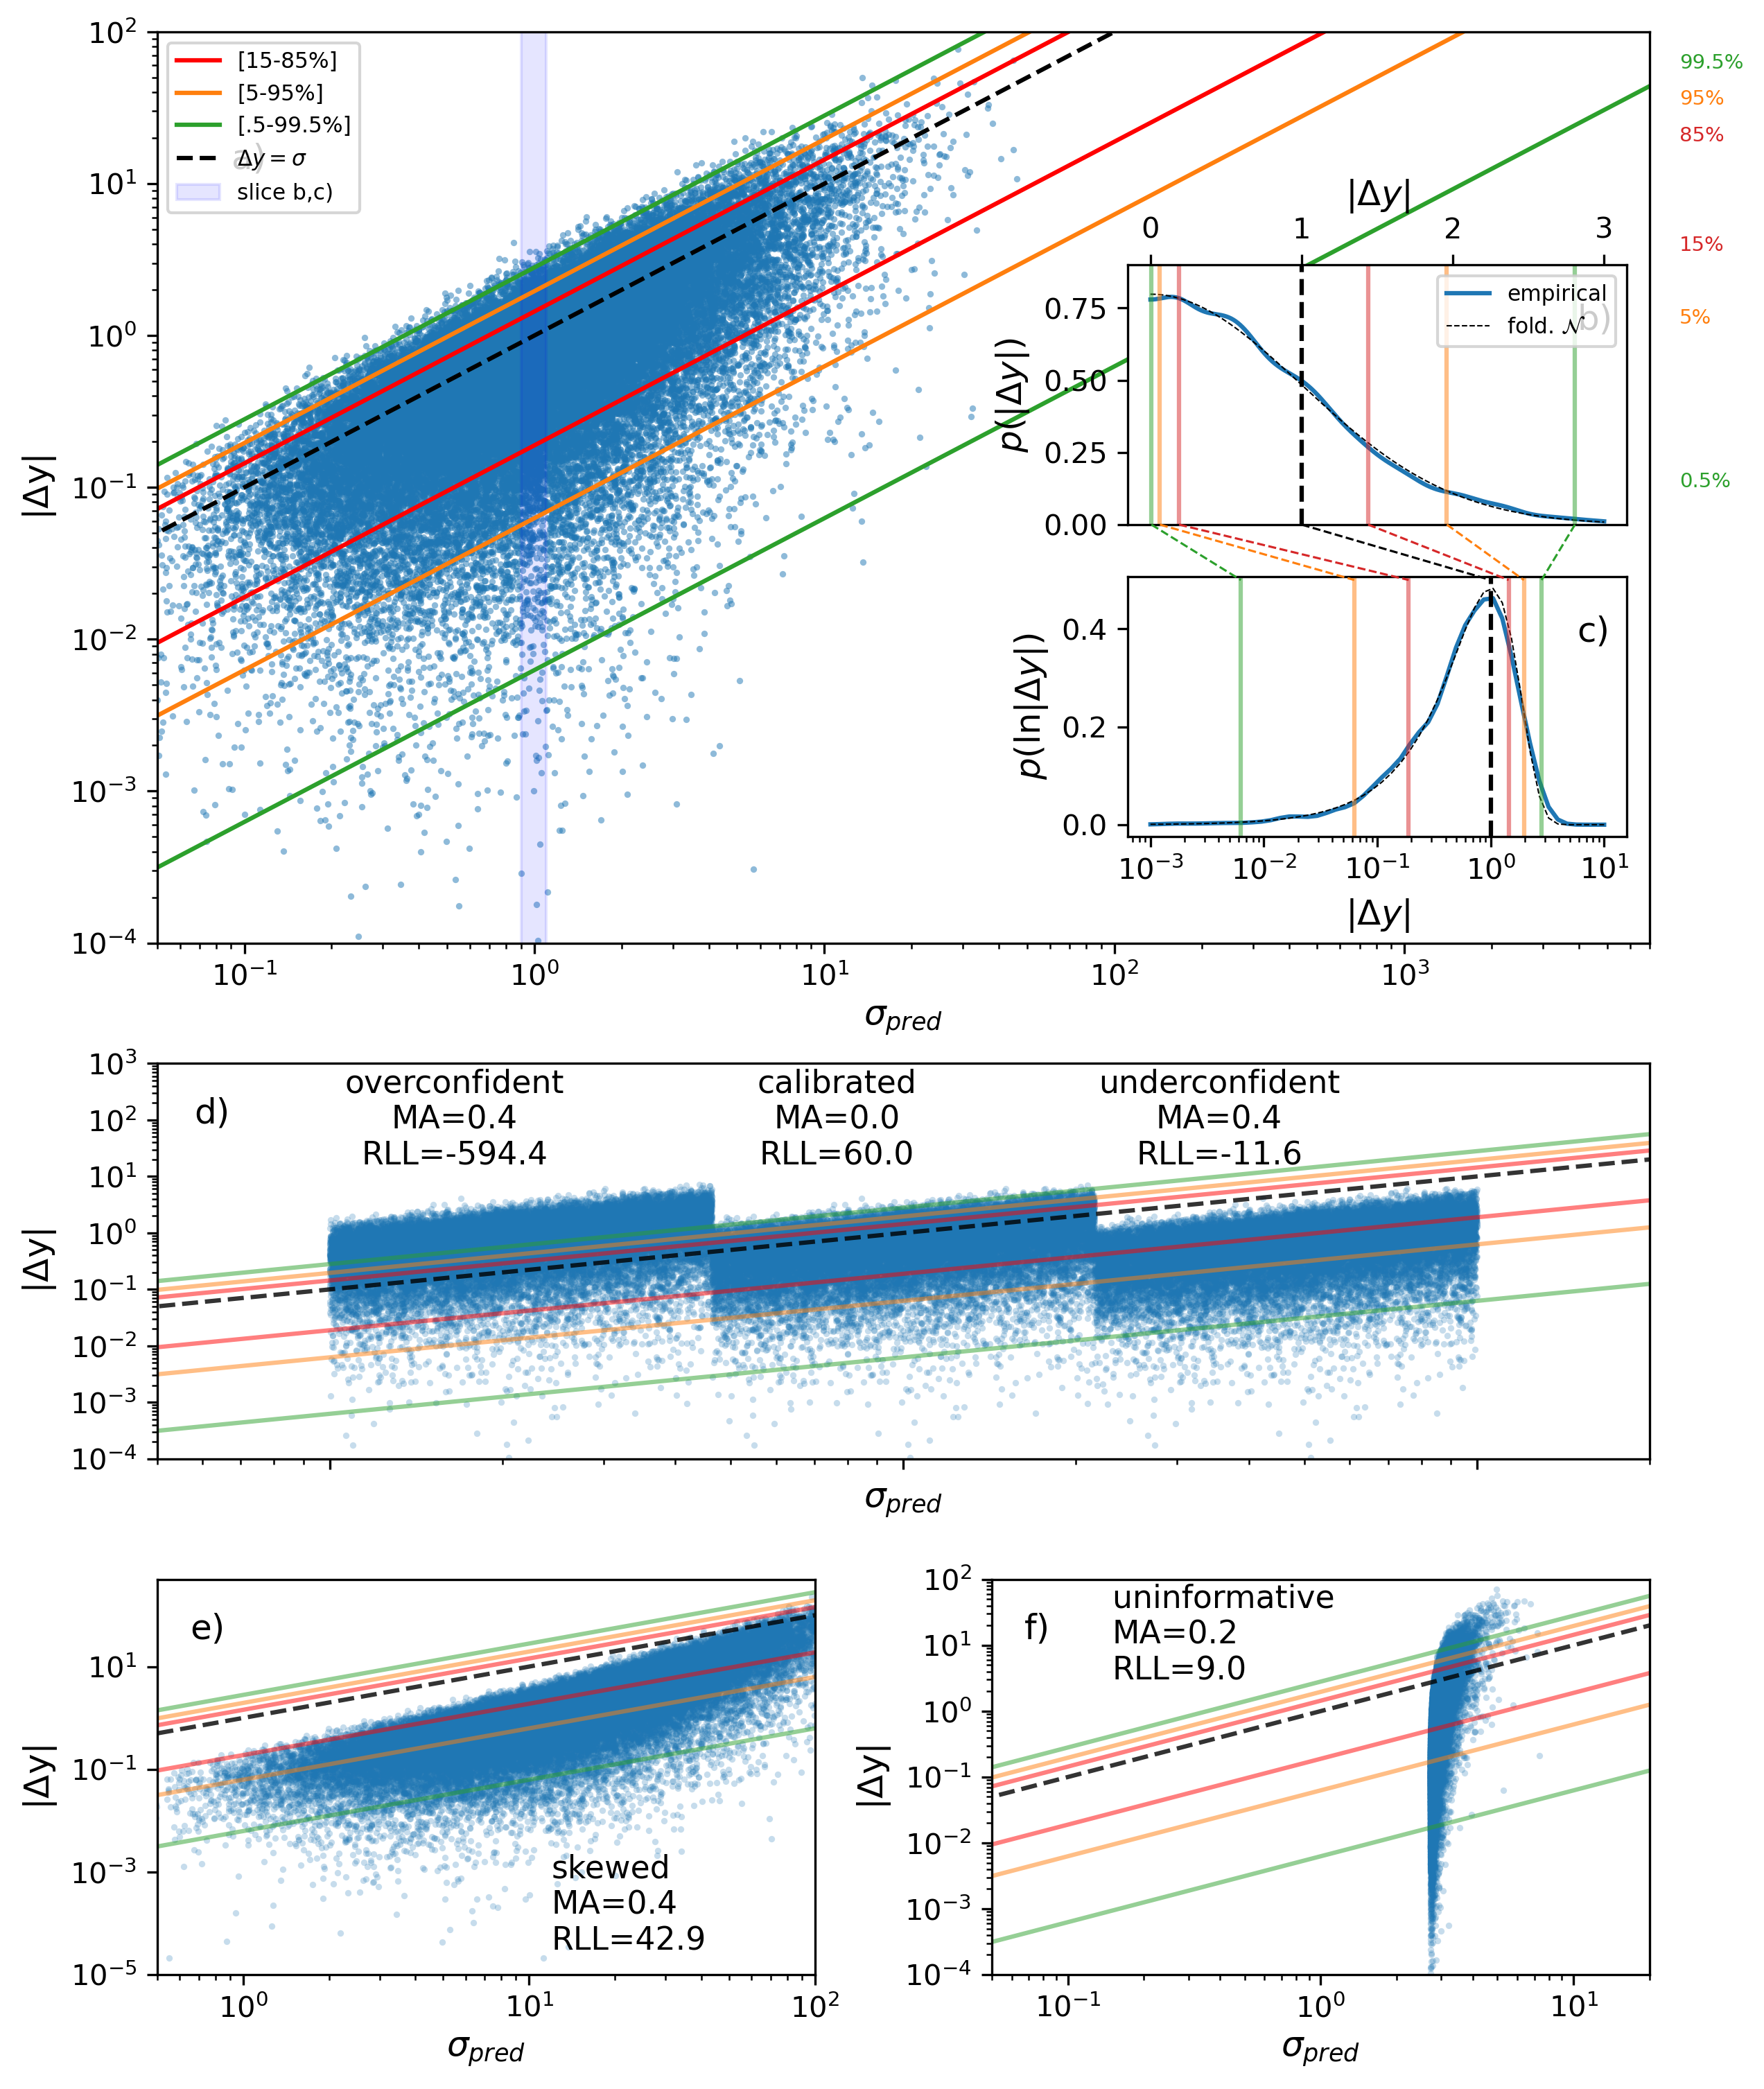

In [47]:
ROUND_DIGITS = 1
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=10.0) 
matplotlib.rc('ytick', labelsize=10.0) 
plt.rc('axes', labelsize=12.)

QUANTILE_ALPHA = 0.5
QUANTILE_ALPHA_UNIT = 0.8
SCATTER_ALPHA = 0.25

POINTS = 50000
np.random.seed(0)

#generate the grid points
#x = np.logspace(-1.,1,POINTS)

x = np.random.lognormal(mean=0.0, sigma=1.0, size=50000)
y = np.zeros(POINTS)

#generate the noise/targets
#noise level is the perfect uncertainty estimate 

noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 

#generate residuals
z = np.abs(y-(y+noise_hetero))


#generate the quantile lines by evaluating the folded normal distribution
# quantile distribution

x_2 = np.logspace(-5.,5.,10)
noise_level_2 = np.abs(x_2)
quantiles_lower_01 = [foldnorm.ppf(0.15, 0.,0.,i) for i in noise_level_2]
quantiles_upper_01 = [foldnorm.ppf(0.85, 0.,0.,i) for i in noise_level_2]
quantiles_lower_05 = [foldnorm.ppf(0.05, 0.,0.,i) for i in noise_level_2]
quantiles_upper_05 = [foldnorm.ppf(0.95, 0.,0.,i) for i in noise_level_2]
quantiles_lower_005 = [foldnorm.ppf(0.005, 0.,0.,i) for i in noise_level_2]
quantiles_upper_005 = [foldnorm.ppf(0.995, 0.,0.,i) for i in noise_level_2]

fig = plt.figure(figsize=(12.0, 10.), dpi=300)
spec = fig.add_gridspec(8, 3)


ax0 = fig.add_subplot(spec[4:6, :2])
ax10 = fig.add_subplot(spec[6:8, 0])
ax11 = fig.add_subplot(spec[6:8, 1])

axexplain  = fig.add_subplot(spec[:4, :2])
axtoy = fig.add_axes([0.45, 0.75, 0.2, 0.125])

axtoy2 = fig.add_axes([0.45, 0.6, 0.2, 0.125])
#axtoy2 = fig.add_subplot(spec[1, 1])
ax0.tick_params(labelbottom=False)

axexplain.scatter(noise_level, z, s=5., color="tab:blue", alpha=0.5, rasterized=True, linewidth=0.)

axexplain.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", rasterized=True, label=r"$\Delta y=\sigma$")

max_slice = 1.1
min_slice = 0.9

axexplain.text(1.02, 0.96, "99.5%", color="tab:green", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.92, "95%", color="tab:orange", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.88, "85%", color="tab:red", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.76, "15%", color="tab:red", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.68, "5%", color="tab:orange", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.5, "0.5%", color="tab:green", fontsize=7, transform=axexplain.transAxes, rasterized=True)

ymin, ymax = axexplain.get_ylim()
axexplain.fill_betweenx([ymin, ymax], min_slice, max_slice, color='b', alpha=0.1, label="slice b,c)")



real_z = z[(noise_level > min_slice) & (noise_level < max_slice)]

kd = sp.stats.gaussian_kde(real_z)
dy = np.linspace(0,3,1000)

#axtoy.hist(real_z, bins=30, color="tab:blue", alpha=0.5, label="slice for b)")
axtoy.plot(dy, (kd(dy)+kd(-dy)), 'tab:blue', label="empirical")
axtoy.plot(dy, 2*np.exp(-dy**2/2)/np.sqrt(2*np.pi), 
              'k--', lw=0.5, label=r"fold. $\mathcal{N}$")

axtoy.axvline(1, color="black", linestyle="--", rasterized=True,)
axtoy.axvline(sp.special.erfinv(0.15)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.85)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.05)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.95)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.005)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.995)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)

#axtoy.legend(fontsize=7.5)

axtoy.xaxis.set_ticks_position('top')
axtoy.xaxis.set_label_position('top')

lkd = sp.stats.gaussian_kde(np.log(real_z))
dy = np.geomspace(1e-3,10)
ldy = np.log(dy)

axtoy2.semilogx(dy, lkd(ldy), 'tab:blue')
axtoy2.plot(dy, 2*dy*np.exp(-dy**2/2)/np.sqrt(2*np.pi), 
              'k--', lw=0.5)

#axtoy2.set_xlim(3e-2, 7000)

quantile_vals = sp.special.erfinv([0.005,0.05,0.15,0.5,0.85,0.95,0.995])*np.sqrt(2)

axtoy.set_ylim(0,0.9)

axtoy2.axvline(1, color="black", linestyle="--", rasterized=True)
axtoy2.axvline(sp.special.erfinv(0.15)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.85)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.05)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.95)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.005)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.995)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)

axtoy.set_ylabel(r"$p(|\Delta y|)$")
axtoy.set_xlabel(r"$|\Delta y|$")
axtoy2.set_xlabel(r"$|\Delta y|$")
axtoy2.set_ylabel(r"$p(\ln|\Delta y|)$")  

iso = sp.special.erfinv([0.005,0.05,0.15,0.5,0.85,0.95,0.995])*np.sqrt(2)

iso[3] = 1
colors = ["tab:green","tab:orange", "tab:red", "k",   "tab:red", "tab:orange", "tab:green",]

for x_c, c in zip(iso, colors): 
    coord_top = axtoy.transData.transform((x_c, 0))
    coord_bottom = axtoy2.transData.transform((x_c, 0.5))
    # Transform display coordinates to figure coordinates
    coord_top_fig = fig.transFigure.inverted().transform(coord_top)
    coord_bottom_fig = fig.transFigure.inverted().transform(coord_bottom)    

    line = plt.Line2D(
        [coord_top_fig[0], coord_bottom_fig[0]],
        [coord_top_fig[1], coord_bottom_fig[1]],
        transform=fig.transFigure, color=c, linestyle='--', lw=0.75
    )
    fig.add_artist(line)

axtoy.text(0.9, 0.75, "b)", fontsize=12, transform=axtoy.transAxes, rasterized=True)
axtoy2.text(0.9, 0.75, "c)", fontsize=12, transform=axtoy2.transAxes, rasterized=True)

axexplain.loglog()
axexplain.set_xlim(0.05,7000)
axexplain.set_ylim(1e-04,1e02)
axexplain.set_ylabel(r"|$\Delta$y|")
axexplain.set_xlabel(r"$\sigma_{pred}$")
axexplain.legend(fontsize=7.5)
axexplain.text(0.05, 0.85, "a)", fontsize=12, transform=axexplain.transAxes, rasterized=True)








    #print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y),\
    #                torch.tensor(y+noise_hetero),\
    #                torch.tensor(tmp_noise)**2)))
    # + "\n" +f"sharpness={round(sharpness,ndigits=3)}",\


ax0.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)
ax0.loglog()

ax0.set_xlim(0.05,20)
ax0.set_ylim(1e-04,1e03)

ax0.set_ylabel(r"|$\Delta$y|")
ax0.set_xlabel(r"$\sigma_{pred}$")
ax0.text(0.025, 0.85, "d)", fontsize=12, transform=ax0.transAxes, rasterized=True)

for a_i, interval, title in zip([5.,1,1/5.,], [(10**(1/3),10**1), (10**-(1/3),10**(1/3)), (10**-1, 10**-(1/3)),],["underconfident","calibrated","overconfident"]):
    tmp_noise = np.copy(noise_level)*a_i
    #only plot point within the range 1e-1 and 1e-2/3
    tmp_noise_sel = (tmp_noise > interval[0]) & (tmp_noise < interval[1])
    
    if a_i != 1:
        ax0.scatter(tmp_noise[tmp_noise_sel], z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    else:
        ax0.scatter(tmp_noise[tmp_noise_sel] , z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    
    #text in the upper left corner with miscalibration area
    
    MA = metrics_calibration.miscalibration_area(y, noise_level*a_i,(y+noise_hetero))
    
    SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(tmp_noise)**2)

    

    ax0.text(interval[0]*1.65, 100, title + "\n" + \
             f"MA={round(MA,ndigits=ROUND_DIGITS)}"\
             + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}",\
            
            horizontalalignment='center',
            verticalalignment='center',)

# now make skewed plots (bia changing the noise level):
alpha=0.5

#introduce weights such that the

noise_level_skewed = np.abs(x) ** (2) + np.abs(x)
noise_hetero_skewed = np.random.normal(y,noise_level_skewed,POINTS) 

z_skewed = np.abs(y-(y+noise_hetero_skewed))
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.scatter(noise_level*alpha_cal, z_skewed, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,1000)
ax10.set_ylim(1e-04,5e02)

MA = metrics_calibration.miscalibration_area(y, noise_level*alpha_cal,(y+noise_hetero_skewed))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero_skewed),\
                    torch.tensor(noise_level*alpha_cal)**2)

#print("mean error:",np.mean(z_skewed**2/(noise_level*alpha_cal)**2))
#print("mean: {}".format(np.mean(z_skewed**2)))
#print("mean var: {}".format(np.mean(noise_level**2)))
#print("mean var cal: {}".format(np.mean((noise_level*alpha_cal)**2)))

#print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y+noise_hetero_skewed),\
#                    torch.tensor(y),\
#                    torch.tensor(noise_level*alpha_cal)**2)))

ax10.text(12
          , 3e-5, "skewed" + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

#get rmse



ax10.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,100)
ax10.set_ylim(1e-05,5e02)
ax10.set_ylabel(r"|$\Delta$y|")
ax10.set_xlabel(r"$\sigma_{pred}$")
ax10.text(0.05, 0.85, "e)", fontsize=12, transform=ax10.transAxes, rasterized=True)




noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 
z = np.abs(y-(y+noise_hetero))

rmse = float(RMSE(torch.tensor(y+noise_hetero),torch.tensor(y)))

uniformative_uq = rmse*np.ones_like(noise_level) + np.abs(x) * 0.1

ax11.scatter(uniformative_uq, z, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
MA = metrics_calibration.miscalibration_area(y, uniformative_uq,(y+noise_hetero))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(uniformative_uq)**2)

ax11.text(.15, 3., "uninformative " + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

ax11.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)


ax11.loglog()
ax11.set_xlim(0.05,20)
ax11.set_ylim(1e-04,1e02)
ax11.set_ylabel(r"|$\Delta$y|")
ax11.set_xlabel(r"$\sigma_{pred}$")
ax11.text(0.05, 0.85, "f)", fontsize=12, transform=ax11.transAxes, rasterized=True)




plt.tight_layout(pad=0.5)
plt.show()

fig.savefig("compound_toy_plot_transposed.pdf",dpi=300, bbox_inches='tight')

AttributeError: 'list' object has no attribute 'x'

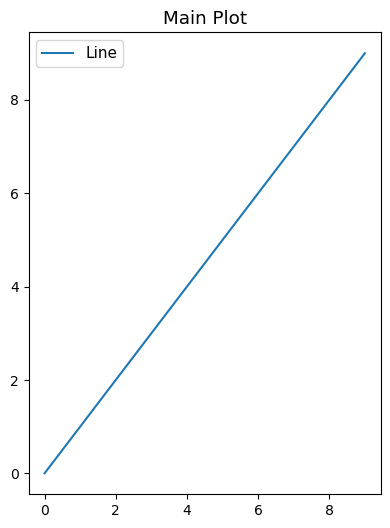

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2) 

ax1 = fig.add_subplot(gs[:, 0])

ax1.plot(range(10), range(10), label="Line")
ax1.set_title("Main Plot")
ax1.legend()

inset_ax.plot(range(1, 6), [x**3 for x in range(1, 6)], 'r')  # Plot something in the inset
inset_ax.set_title("Inset Plot")

inset_ax.plot(range(1, 6), [x**2 for x in range(1, 6)], color='r', label="Inset Line")
inset_ax.set_title("Inset Plot")
inset_ax.legend()

plt.show

In [ ]:
quantiles_lower_05 = [foldnorm.ppf(0.05, 0.,0.,i) for i in noise_level_2]

In [32]:
foldnorm.ppf(0.5, 0.,0.,1.)

0.6744897501960817

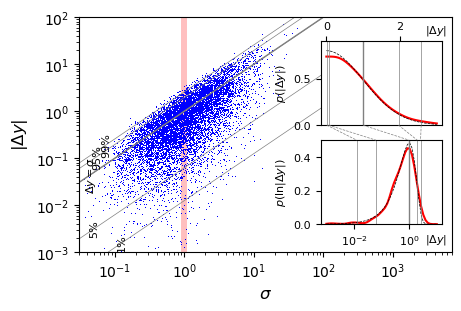

In [35]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

npoints = 10000
x = np.exp(np.random.normal(size=npoints))
y = np.random.normal(size=npoints) * x

fig, ax = plt.subplots(figsize=(4.5, 3), constrained_layout=True)

# Main plot
s1 = np.where((x < 1.1) & (x > 0.9))[0]
ax.axvspan(0.9, 1.1, 1e-4, 100, color='r', alpha=0.25, lw=0)
ax.loglog(x, np.abs(y), 'b,')
ax.set_xlim(3e-2, 7000)
ax.set_ylim(1e-3, 100)
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$|\Delta y|$")
ax.plot([1e-2, 1e2], [1e-2, 1e2], '-', c='gray', lw=1)

# Inset 1: Linear x scale
ax_inset1 = fig.add_axes([0.7, 0.6, 0.27, 0.28])  # adjust position as needed
kd = sp.stats.gaussian_kde(y[s1])
dy = np.linspace(0, 3, 100)
ax_inset1.plot(dy, (kd(dy) + kd(-dy)), 'r-')
ax_inset1.plot(dy, 2 * np.exp(-dy ** 2 / 2) / np.sqrt(2 * np.pi), 'k--', lw=0.5)
ax_inset1.set_xlabel(r"$|\Delta y|$", labelpad=-10, fontsize=8)
ax_inset1.set_ylabel(r"$p(|\Delta y|)$", fontsize=8)
ax_inset1.axvline(1, 0, 1, ls='-', c='gray', lw=1)
ax_inset1.set_ylim(0,0.9)
ax_inset1.tick_params(labelsize=8)  

# Inset 2: Log x scale
ax_inset2 = fig.add_axes([0.7, 0.27, 0.27, 0.28])  # adjust position as needed
lkd = sp.stats.gaussian_kde(np.log(np.abs(y[s1])))
dy = np.geomspace(1e-3, 10)
ldy = np.log(dy)
ax_inset2.semilogx(dy, lkd(ldy), 'r-')
ax_inset2.plot(dy, 2 * dy * np.exp(-dy ** 2 / 2) / np.sqrt(2 * np.pi), 'k--', lw=0.5)
ax_inset2.set_xlabel(r"$|\Delta y|$", labelpad=-10, fontsize=8)
ax_inset2.set_ylabel(r"$p(\ln|\Delta y|)$", fontsize=8)
ax_inset2.axvline(1, 0, 1, ls='-', c='gray', lw=1)
ax_inset2.set_ylim(0,0.5)
ax_inset2.tick_params(labelsize=8)  

# Set ticks on top for the first inset
ax_inset1.xaxis.set_ticks_position('top')
ax_inset1.xaxis.set_label_position('top')
ax_inset1.xaxis.set_label_coords(0.95, 1.1)  # x and y coordinates in axes fraction
ax_inset2.xaxis.set_label_coords(0.95, -0.1)

iso = sp.special.erfinv([0.01, 0.05, 0.68, 0.95, 0.99]) * np.sqrt(2)
isolabx = 0.05
isotxt = ["1%", "5%", r"$\Delta y = \sigma$", "95%", "99%"]
dlx = [2.5, 1, 0.9, 1.1, 1.5]
for i, l, dx in zip(iso, isotxt, dlx):
    ax.plot([1e-2, 1e2], [1e-2 * i, 1e2 * i], '-', c='gray', lw=0.5)
    ax.text(isolabx * dx, isolabx * dx * i, l, rotation=90, va='center', ha='center', color='black', fontsize=8)

    ax_inset1.axvline(i, 0, 1, ls='-', c='gray', lw=0.5)
    ax_inset2.axvline(i, 0, 1, ls='-', c='gray', lw=0.5)

for x in iso: 
    coord_top = ax_inset1.transData.transform((x, 0))
    coord_bottom = ax_inset2.transData.transform((x, 0.5))
    # Transform display coordinates to figure coordinates
    coord_top_fig = fig.transFigure.inverted().transform(coord_top)
    coord_bottom_fig = fig.transFigure.inverted().transform(coord_bottom)    

    line = plt.Line2D(
        [coord_top_fig[0], coord_bottom_fig[0]],
        [coord_top_fig[1], coord_bottom_fig[1]],
        transform=fig.transFigure, color='gray', linestyle='--', lw=0.5
    )
    fig.add_artist(line)

In [53]:
?fig.add_gridspec

Signature: fig.add_gridspec(nrows=1, ncols=1, **kwargs)
Docstring:
Return a `.GridSpec` that has this figure as a parent.  This allows
complex layout of Axes in the figure.

Parameters
----------
nrows : int, default: 1
    Number of rows in grid.

ncols : int, default: 1
    Number of columns in grid.

Returns
-------
`.GridSpec`

Other Parameters
----------------
**kwargs
    Keyword arguments are passed to `.GridSpec`.

See Also
--------
matplotlib.pyplot.subplots

Examples
--------
Adding a subplot that spans two rows::

    fig = plt.figure()
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    # spans two rows:
    ax3 = fig.add_subplot(gs[:, 1])
File:      /opt/anaconda3/envs/metatensor_BPNN/lib/python3.10/site-packages/matplotlib/figure.py
Type:      method

/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_37770/1659395822.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


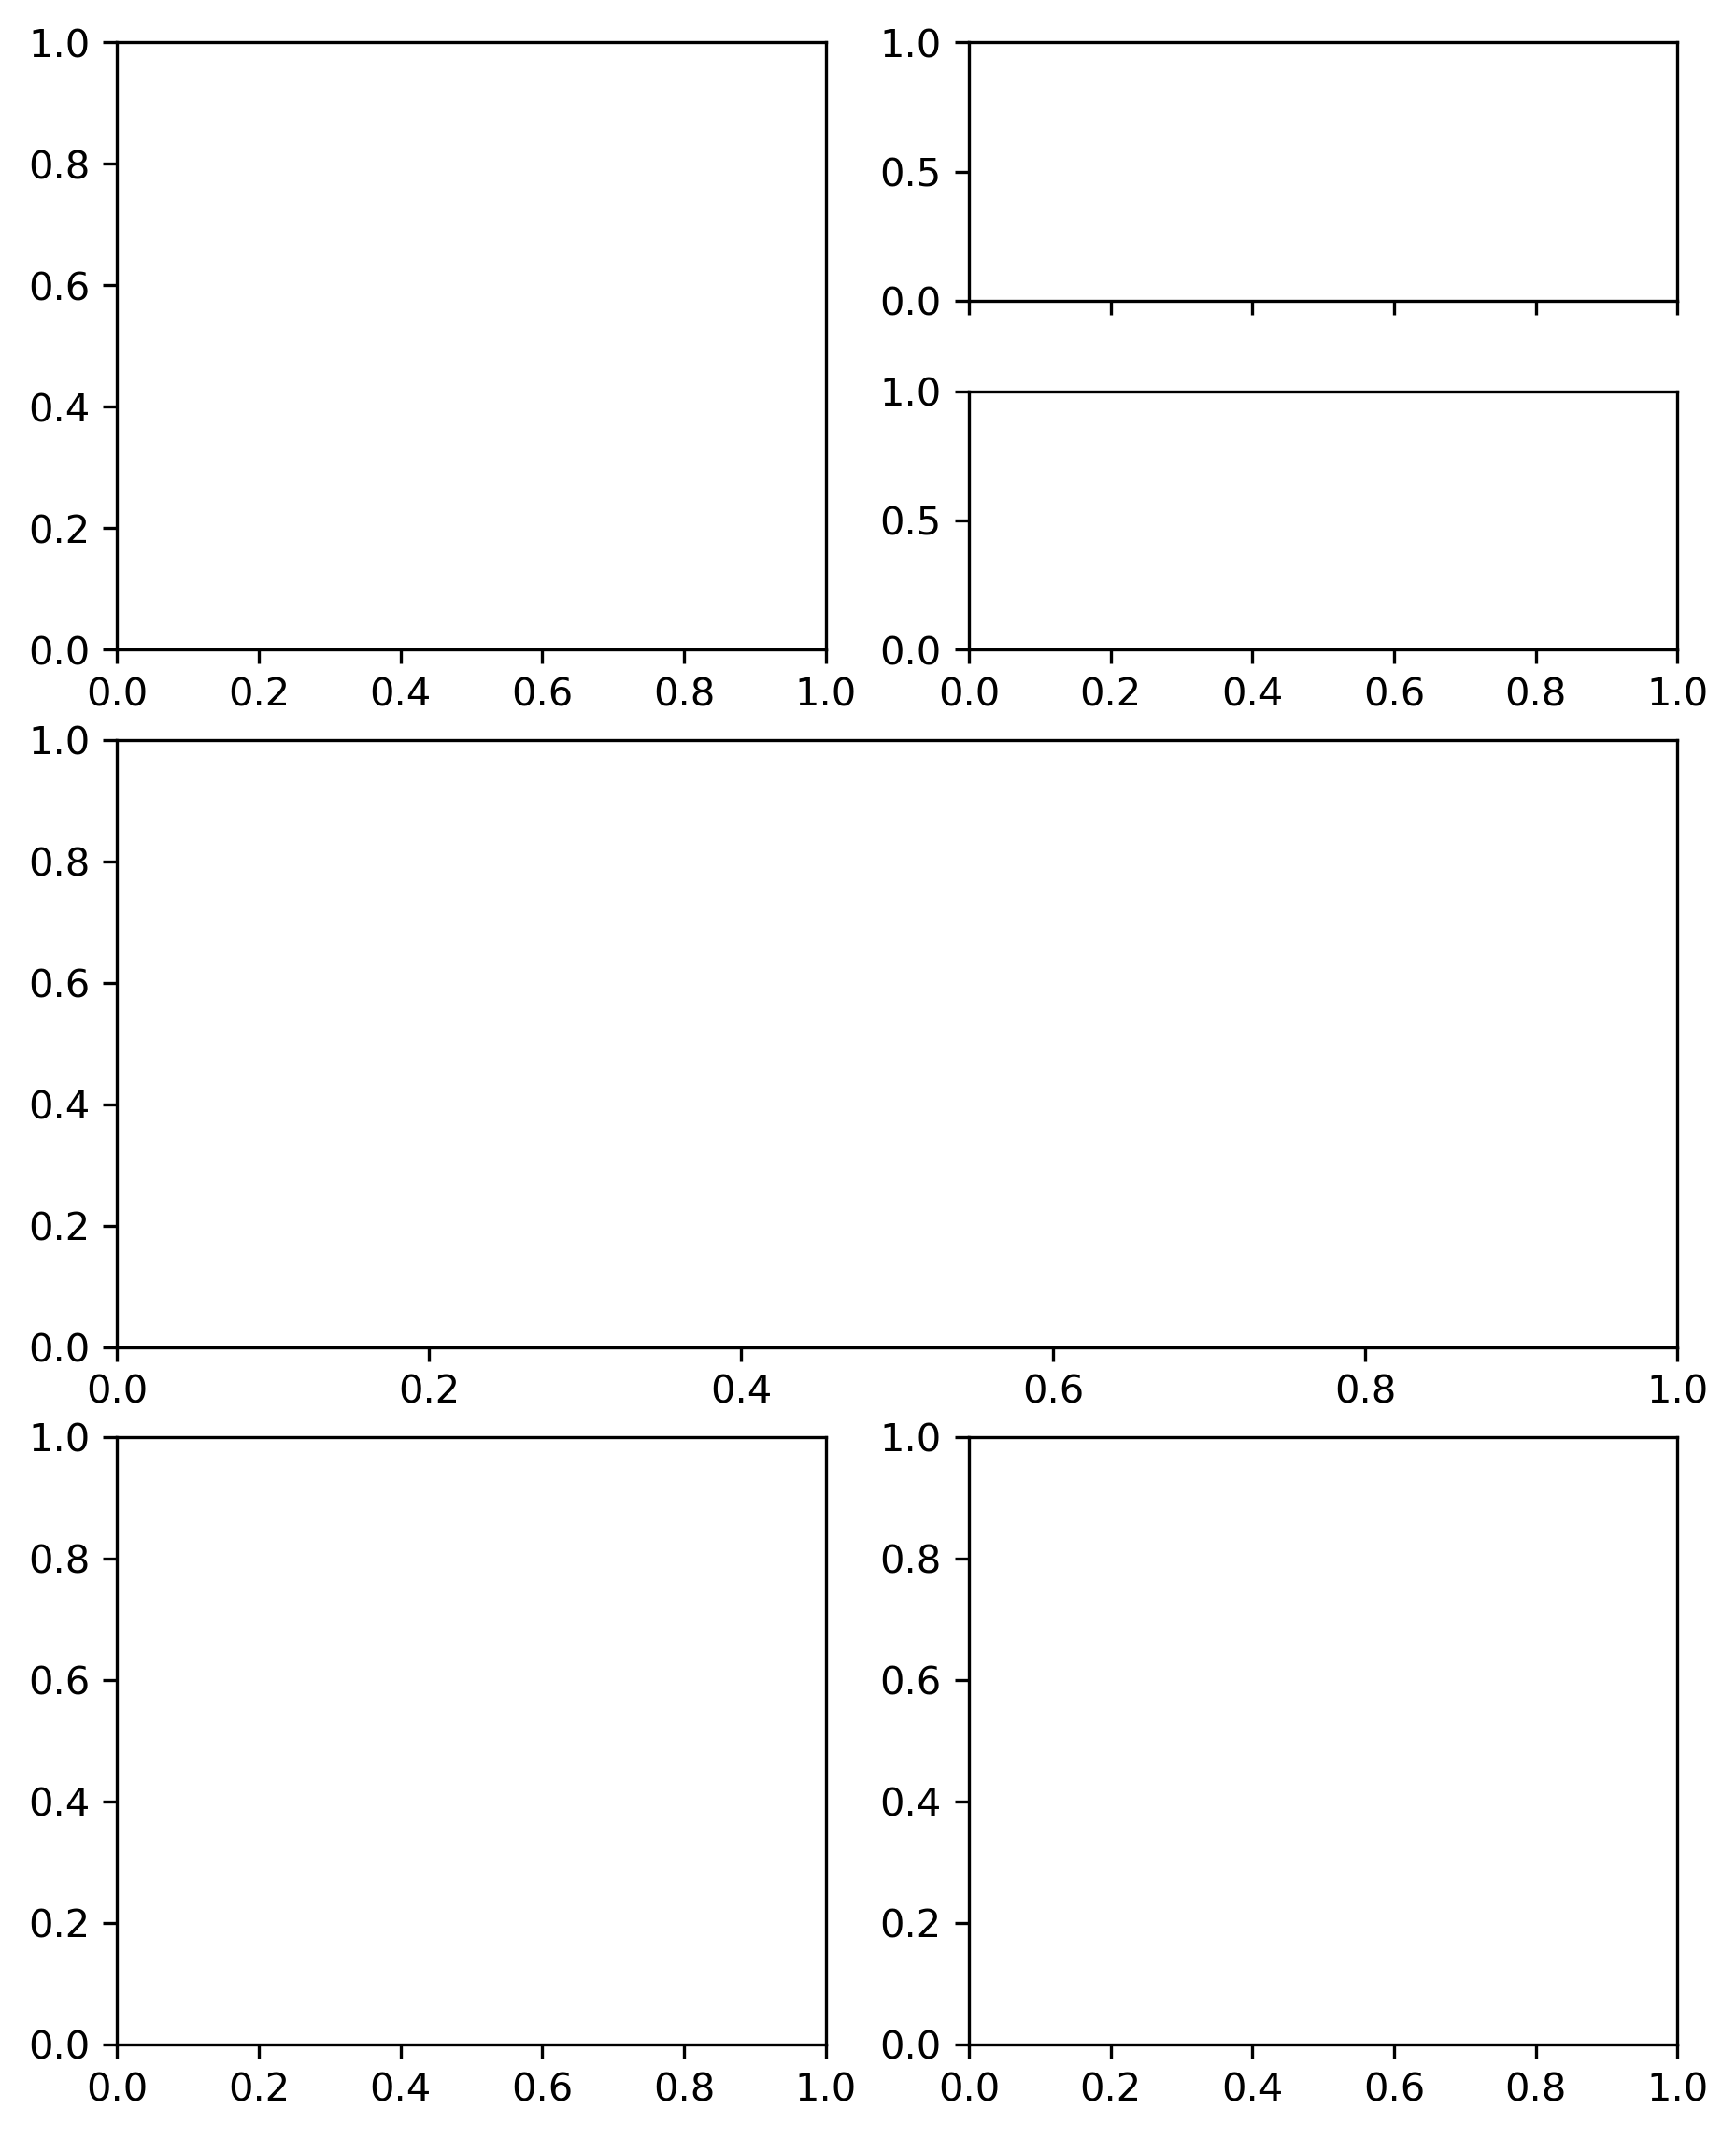

In [77]:
fig = plt.figure(figsize=(9.0, 7.5), dpi=300)
spec = fig.add_gridspec(6, 3)

#ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 1], sharex=ax1) 
ax1.tick_params(labelbottom=False)

#ax3 = fig.add_subplot(spec[1, 0])

#upper left
ax3 = fig.add_subplot(spec[:2, 0])

ax4 = fig.add_subplot(spec[2:4, :2])

ax5 = fig.add_subplot(spec[4:, 0])
ax5 = fig.add_subplot(spec[4:, 1])

plt.tight_layout(pad=0.25)
fig.show()

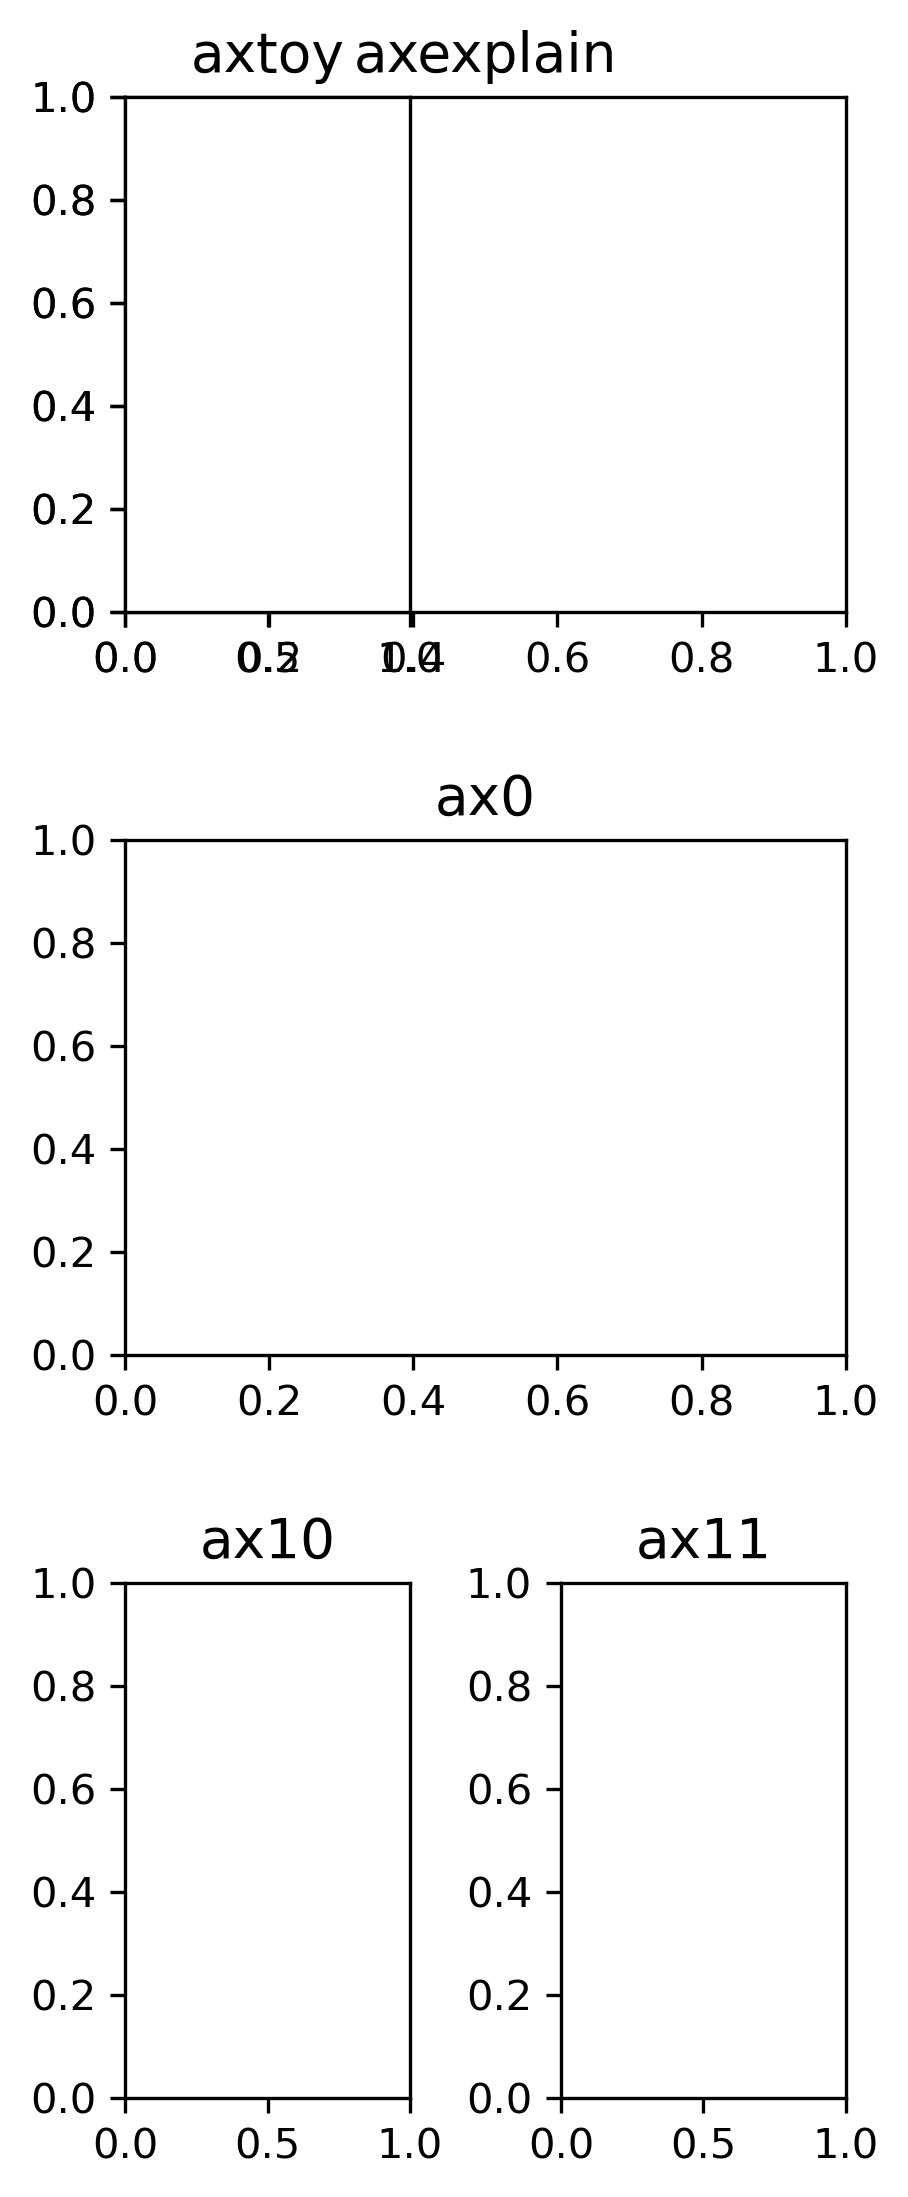

In [48]:
fig = plt.figure(figsize=(9.0, 7.5), dpi=300)
spec = fig.add_gridspec(3, 6)  # Define a grid layout

# Create subplots in specific cells of the grid
ax0 = fig.add_subplot(spec[1, :2])  # Span first two columns in the second row
ax10 = fig.add_subplot(spec[2, 0])  # First column in the third row
ax11 = fig.add_subplot(spec[2, 1])  # Second column in the third row

axexplain = fig.add_subplot(spec[0, :2])  # First column in the first row

# Change axtoy to span two vertically stacked cells in the second column
axtoy = fig.add_subplot(spec[0, 0])  # Modify this line for vertical stacking

# Optional: Add titles to each subplot to identify them
ax0.set_title("ax0")
ax10.set_title("ax10")
ax11.set_title("ax11")
axexplain.set_title("axexplain")
axtoy.set_title("axtoy")

plt.tight_layout(pad=0.50)
# Display the figure layout
plt.show()


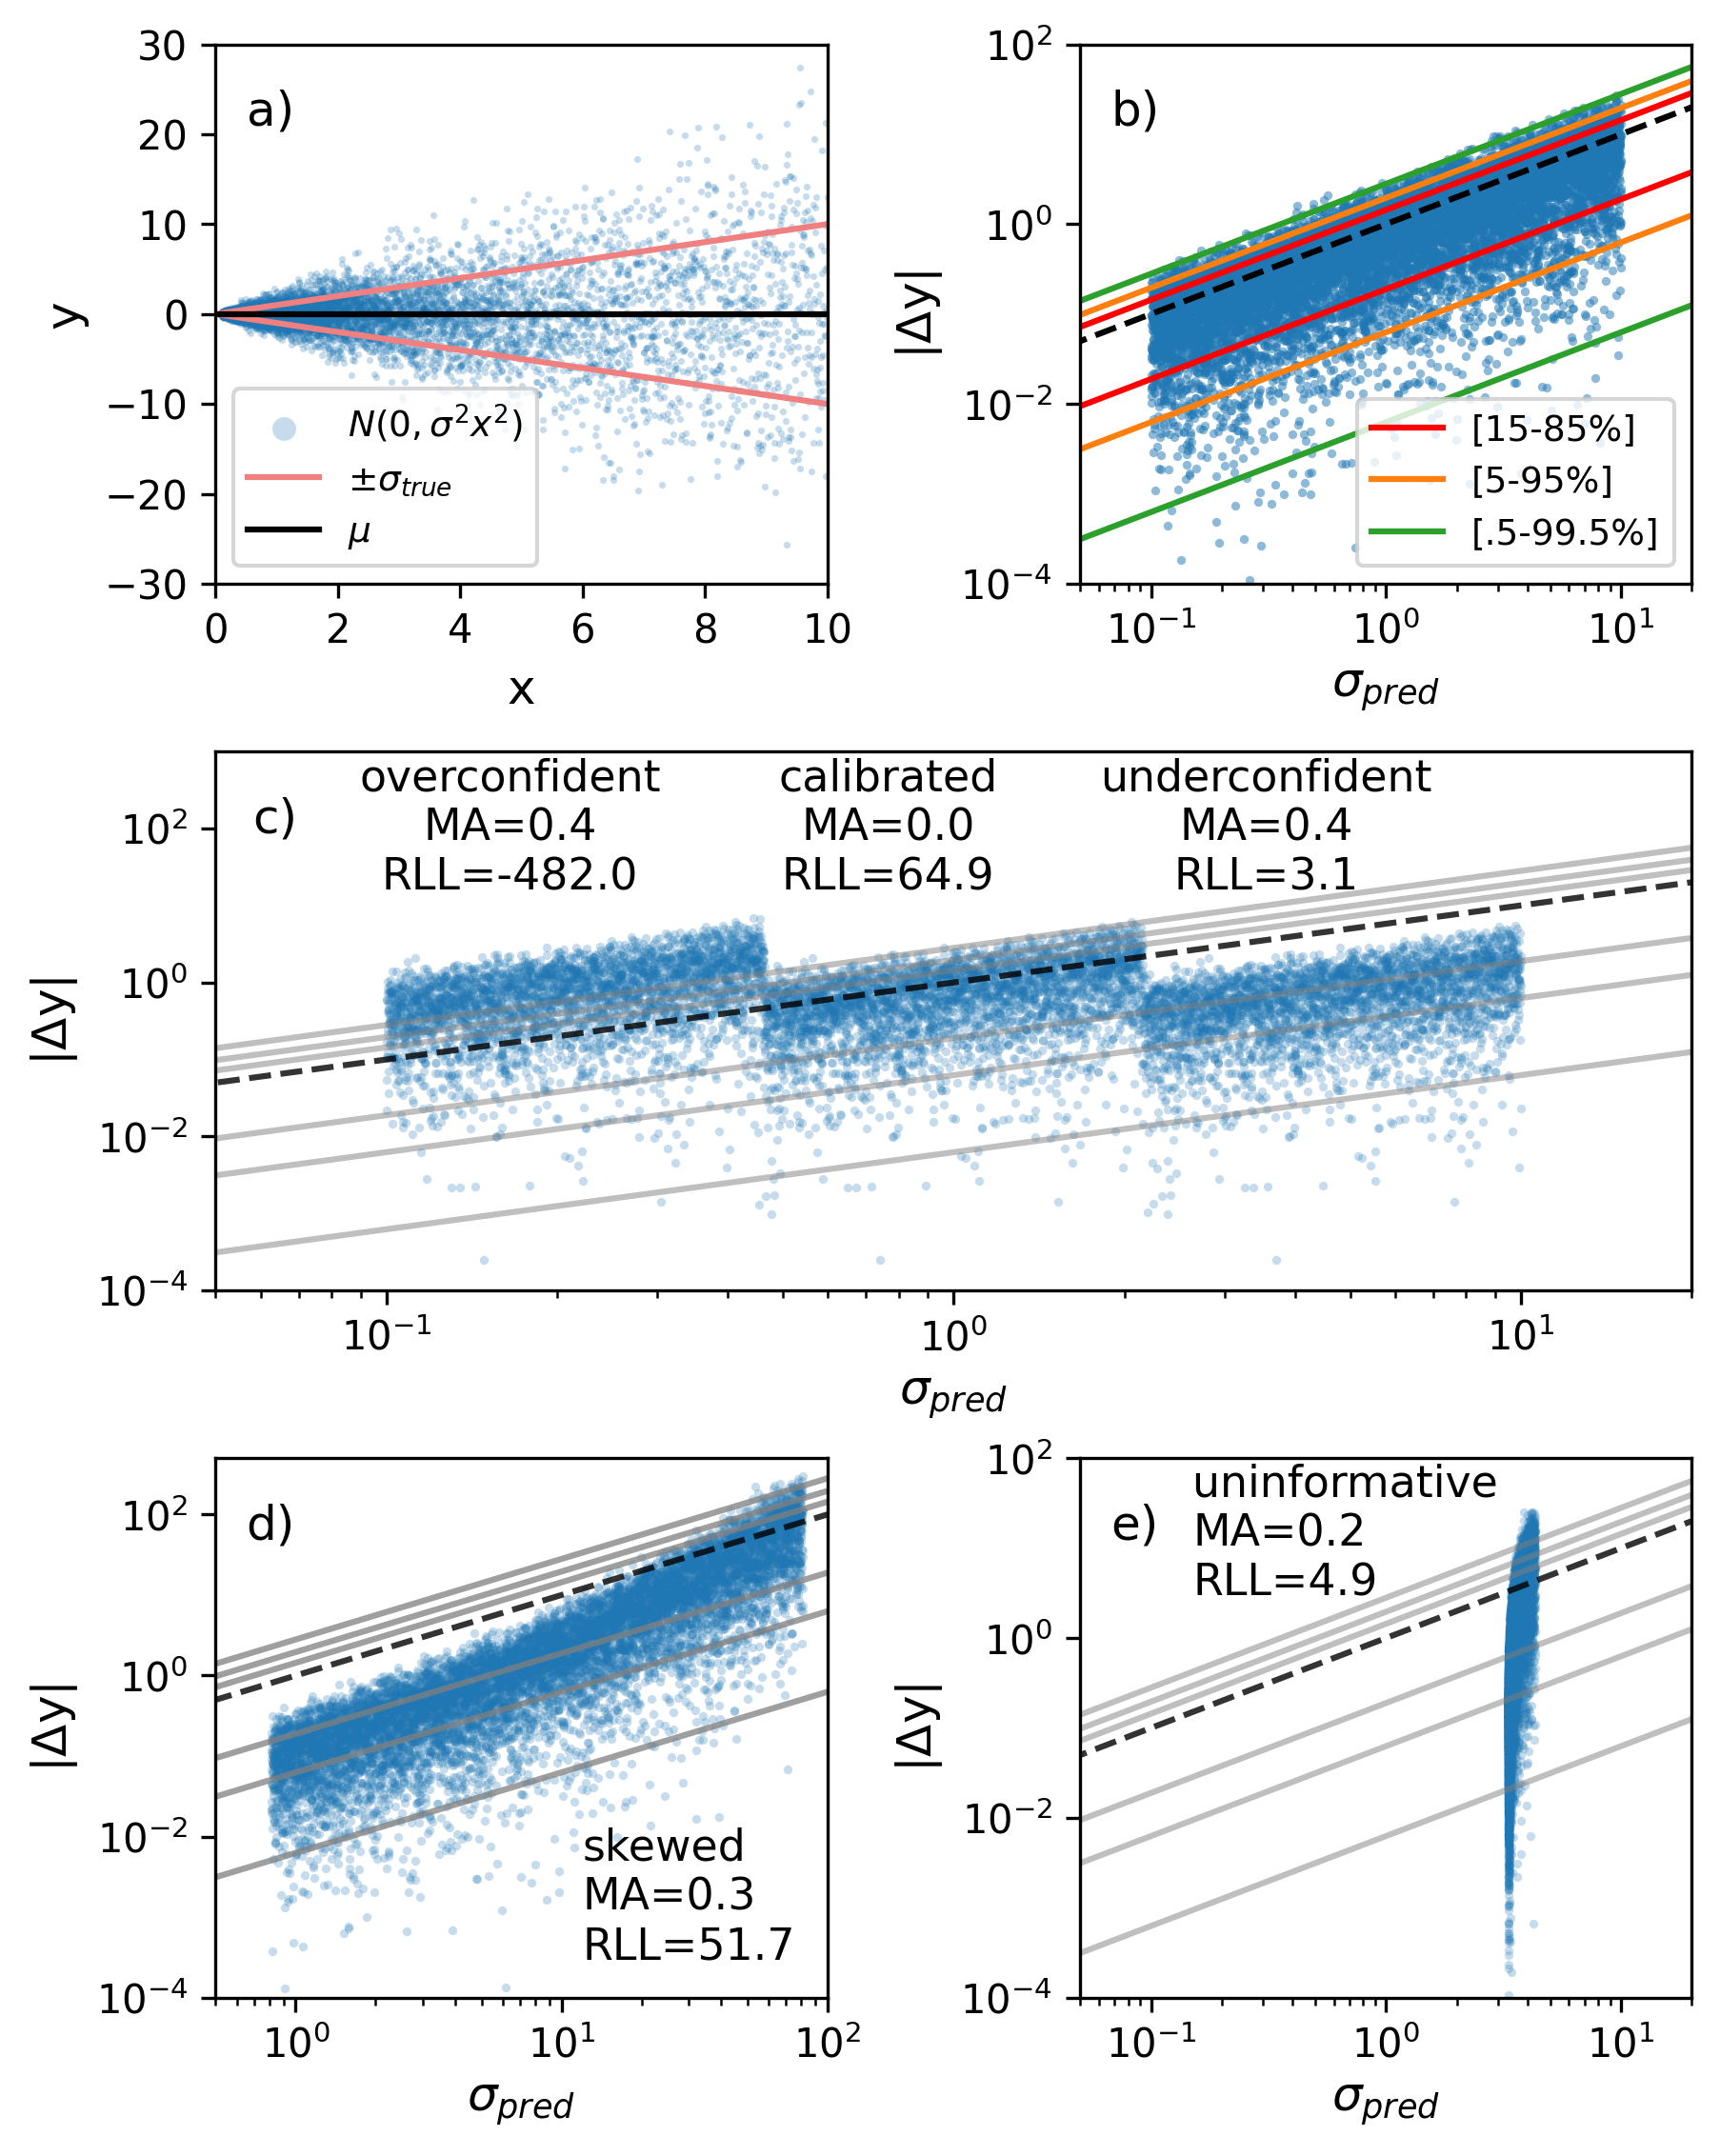

In [ ]:
ROUND_DIGITS = 1
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=10.0) 
matplotlib.rc('ytick', labelsize=10.0) 
plt.rc('axes', labelsize=12.)

QUANTILE_ALPHA = 0.5
QUANTILE_ALPHA_UNIT = 0.8
SCATTER_ALPHA = 0.25

POINTS =10000
np.random.seed(0)

#generate the grid points
x = np.logspace(-1.,1,POINTS)
y = np.zeros(POINTS)

#generate the noise/targets
#noise level is the perfect uncertainty estimate 

noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 

#generate residuals
z = np.abs(y-(y+noise_hetero))



#generate the quantile lines by evaluating the folded normal distribution
# quantile distribution

x_2 = np.logspace(-5.,5.,10)
noise_level_2 = np.abs(x_2)
quantiles_lower_01 = [foldnorm.ppf(0.15, 0.,0.,i) for i in noise_level_2]
quantiles_upper_01 = [foldnorm.ppf(0.85, 0.,0.,i) for i in noise_level_2]
quantiles_lower_05 = [foldnorm.ppf(0.05, 0.,0.,i) for i in noise_level_2]
quantiles_upper_05 = [foldnorm.ppf(0.95, 0.,0.,i) for i in noise_level_2]
quantiles_lower_005 = [foldnorm.ppf(0.005, 0.,0.,i) for i in noise_level_2]
quantiles_upper_005 = [foldnorm.ppf(0.995, 0.,0.,i) for i in noise_level_2]

fig = plt.figure(figsize=(9.0, 7.5), dpi=300)
spec = fig.add_gridspec(3, 3)


ax0 = fig.add_subplot(spec[1, :2])
ax10 = fig.add_subplot(spec[2, 0])
ax11 = fig.add_subplot(spec[2, 1])

axtoy = fig.add_subplot(spec[0, 0])
axexplain = fig.add_subplot(spec[0, 1])

axtoy.scatter(x,y+noise_hetero,s=3., alpha=SCATTER_ALPHA, rasterized=True, linewidth=0. )
axtoy.scatter([],[],label=r"$N(0,\sigma^2 x^2)$", alpha=SCATTER_ALPHA, linewidth=0., color="tab:blue" )
axtoy.plot(x,y+noise_level, color="lightcoral", label=r"$\pm \sigma_{true}$", rasterized=True)
#plt.plot(x,y+1/alpha*noise_level, color="tab:red", label=r"$\sigma_{pred}$")
axtoy.plot(x,y-noise_level, color="lightcoral", rasterized=True)
#plt.plot(x,y-1/alpha*noise_level, color="tab:red",)
axtoy.axhline(0,  color="black", label=r"$\mu$", rasterized=True)
axtoy.text(0.05, 0.85, "a)", fontsize=12, transform=axtoy.transAxes, rasterized=True)
axtoy.legend(loc="lower left",fontsize=9.)
axtoy.set_ylim(-30,30)
axtoy.set_xlim(0,10)
axtoy.set_xlabel("x")
axtoy.set_ylabel("y")









axexplain.scatter(noise_level, z, s=5., color="tab:blue", alpha=0.5, rasterized=True, linewidth=0.)

axexplain.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", rasterized=True)


axexplain.loglog()
axexplain.set_xlim(0.05,20)
axexplain.set_ylim(1e-04,1e02)
axexplain.set_ylabel(r"|$\Delta$y|")
axexplain.set_xlabel(r"$\sigma_{pred}$")
axexplain.legend(fontsize=9.)
axexplain.text(0.05, 0.85, "b)", fontsize=12, transform=axexplain.transAxes, rasterized=True)





for a_i, interval, title in zip([5.,1,1/5.,], [(10**(1/3),10**1), (10**-(1/3),10**(1/3)), (10**-1, 10**-(1/3)),],["underconfident","calibrated","overconfident"]):
    tmp_noise = np.copy(noise_level)*a_i
    #only plot point within the range 1e-1 and 1e-2/3
    tmp_noise_sel = (tmp_noise > interval[0]) & (tmp_noise < interval[1])
    
    if a_i != 1:
        ax0.scatter(tmp_noise[tmp_noise_sel], z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    else:
        ax0.scatter(tmp_noise[tmp_noise_sel] , z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    
    #text in the upper left corner with miscalibration area
    
    MA = metrics_calibration.miscalibration_area(y, noise_level*a_i,(y+noise_hetero))
    
    SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(tmp_noise)**2)

    

    ax0.text(interval[0]*1.65, 100, title + "\n" + \
             f"MA={round(MA,ndigits=ROUND_DIGITS)}"\
             + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}",\
            
            horizontalalignment='center',
            verticalalignment='center',)

    #print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y),\
    #                torch.tensor(y+noise_hetero),\
    #                torch.tensor(tmp_noise)**2)))
    # + "\n" +f"sharpness={round(sharpness,ndigits=3)}",\

ax0.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)
ax0.loglog()

ax0.set_xlim(0.05,20)
ax0.set_ylim(1e-04,1e03)

ax0.set_ylabel(r"|$\Delta$y|")
ax0.set_xlabel(r"$\sigma_{pred}$")
ax0.text(0.025, 0.85, "c)", fontsize=12, transform=ax0.transAxes, rasterized=True)


# now make skewed plots (bia changing the noise level):
alpha=0.5

#introduce weights such that the

noise_level_skewed = np.abs(x) ** (2) + np.abs(x)
noise_hetero_skewed = np.random.normal(y,noise_level_skewed,POINTS) 

z_skewed = np.abs(y-(y+noise_hetero_skewed))
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.scatter(noise_level*alpha_cal, z_skewed, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
ax10.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,1000)
ax10.set_ylim(1e-04,5e02)

MA = metrics_calibration.miscalibration_area(y, noise_level*alpha_cal,(y+noise_hetero_skewed))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero_skewed),\
                    torch.tensor(noise_level*alpha_cal)**2)

#print("mean error:",np.mean(z_skewed**2/(noise_level*alpha_cal)**2))
#print("mean: {}".format(np.mean(z_skewed**2)))
#print("mean var: {}".format(np.mean(noise_level**2)))
#print("mean var cal: {}".format(np.mean((noise_level*alpha_cal)**2)))

#print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y+noise_hetero_skewed),\
#                    torch.tensor(y),\
#                    torch.tensor(noise_level*alpha_cal)**2)))

ax10.text(12
          , 3e-4, "skewed" + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

#get rmse

ax10.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,100)
ax10.set_ylim(1e-04,5e02)
ax10.set_ylabel(r"|$\Delta$y|")
ax10.set_xlabel(r"$\sigma_{pred}$")
ax10.text(0.05, 0.85, "d)", fontsize=12, transform=ax10.transAxes, rasterized=True)




noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 
z = np.abs(y-(y+noise_hetero))

rmse = float(RMSE(torch.tensor(y+noise_hetero),torch.tensor(y)))

uniformative_uq = rmse*np.ones_like(noise_level) + np.abs(x) * 0.1

ax11.scatter(uniformative_uq, z, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
MA = metrics_calibration.miscalibration_area(y, uniformative_uq,(y+noise_hetero))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(uniformative_uq)**2)

ax11.text(.15, 3., "uninformative " + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

ax11.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)


ax11.loglog()
ax11.set_xlim(0.05,20)
ax11.set_ylim(1e-04,1e02)
ax11.set_ylabel(r"|$\Delta$y|")
ax11.set_xlabel(r"$\sigma_{pred}$")
ax11.text(0.05, 0.85, "e)", fontsize=12, transform=ax11.transAxes, rasterized=True)



plt.tight_layout(pad=0.50)
plt.show()

fig.savefig("compound_toy_plot_transposed.pdf",dpi=300, bbox_inches='tight')

In [ ]:
ROUND_DIGITS = 1
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=10.0) 
matplotlib.rc('ytick', labelsize=10.0) 
plt.rc('axes', labelsize=12.)

QUANTILE_ALPHA = 0.5
QUANTILE_ALPHA_UNIT = 0.8
SCATTER_ALPHA = 0.25

POINTS =10000
np.random.seed(0)

#generate the grid points
x = np.logspace(-1.,1,POINTS)
y = np.zeros(POINTS)

#generate the noise/targets
#noise level is the perfect uncertainty estimate 

noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 

#generate residuals
z = np.abs(y-(y+noise_hetero))



#generate the quantile lines by evaluating the folded normal distribution
# quantile distribution

x_2 = np.logspace(-5.,5.,10)
noise_level_2 = np.abs(x_2)
quantiles_lower_01 = [foldnorm.ppf(0.15, 0.,0.,i) for i in noise_level_2]
quantiles_upper_01 = [foldnorm.ppf(0.85, 0.,0.,i) for i in noise_level_2]
quantiles_lower_05 = [foldnorm.ppf(0.05, 0.,0.,i) for i in noise_level_2]
quantiles_upper_05 = [foldnorm.ppf(0.95, 0.,0.,i) for i in noise_level_2]
quantiles_lower_005 = [foldnorm.ppf(0.005, 0.,0.,i) for i in noise_level_2]
quantiles_upper_005 = [foldnorm.ppf(0.995, 0.,0.,i) for i in noise_level_2]

fig = plt.figure(figsize=(9.0, 7.5), dpi=300)
spec = fig.add_gridspec(3, 3)


ax0 = fig.add_subplot(spec[1, :2])
ax10 = fig.add_subplot(spec[2, 0])
ax11 = fig.add_subplot(spec[2, 1])

axtoy = fig.add_subplot(spec[0, 0])
axexplain = fig.add_subplot(spec[0, 1])

axtoy.scatter(x,y+noise_hetero,s=3., alpha=SCATTER_ALPHA, rasterized=True, linewidth=0. )
axtoy.scatter([],[],label=r"$N(0,\sigma^2 x^2)$", alpha=SCATTER_ALPHA, linewidth=0., color="tab:blue" )
axtoy.plot(x,y+noise_level, color="lightcoral", label=r"$\pm \sigma_{true}$", rasterized=True)
#plt.plot(x,y+1/alpha*noise_level, color="tab:red", label=r"$\sigma_{pred}$")
axtoy.plot(x,y-noise_level, color="lightcoral", rasterized=True)
#plt.plot(x,y-1/alpha*noise_level, color="tab:red",)
axtoy.axhline(0,  color="black", label=r"$\mu$", rasterized=True)
axtoy.text(0.05, 0.85, "a)", fontsize=12, transform=axtoy.transAxes, rasterized=True)
axtoy.legend(loc="lower left",fontsize=9.)
axtoy.set_ylim(-30,30)
axtoy.set_xlim(0,10)
axtoy.set_xlabel("x")
axtoy.set_ylabel("y")









axexplain.scatter(noise_level, z, s=5., color="tab:blue", alpha=0.5, rasterized=True, linewidth=0.)

axexplain.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", rasterized=True)


axexplain.loglog()
axexplain.set_xlim(0.05,20)
axexplain.set_ylim(1e-04,1e02)
axexplain.set_ylabel(r"|$\Delta$y|")
axexplain.set_xlabel(r"$\sigma_{pred}$")
axexplain.legend(fontsize=9.)
axexplain.text(0.05, 0.85, "b)", fontsize=12, transform=axexplain.transAxes, rasterized=True)





for a_i, interval, title in zip([5.,1,1/5.,], [(10**(1/3),10**1), (10**-(1/3),10**(1/3)), (10**-1, 10**-(1/3)),],["underconfident","calibrated","overconfident"]):
    tmp_noise = np.copy(noise_level)*a_i
    #only plot point within the range 1e-1 and 1e-2/3
    tmp_noise_sel = (tmp_noise > interval[0]) & (tmp_noise < interval[1])
    
    if a_i != 1:
        ax0.scatter(tmp_noise[tmp_noise_sel], z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    else:
        ax0.scatter(tmp_noise[tmp_noise_sel] , z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    
    #text in the upper left corner with miscalibration area
    
    MA = metrics_calibration.miscalibration_area(y, noise_level*a_i,(y+noise_hetero))
    
    SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(tmp_noise)**2)

    

    ax0.text(interval[0]*1.65, 100, title + "\n" + \
             f"MA={round(MA,ndigits=ROUND_DIGITS)}"\
             + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}",\
            
            horizontalalignment='center',
            verticalalignment='center',)

    #print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y),\
    #                torch.tensor(y+noise_hetero),\
    #                torch.tensor(tmp_noise)**2)))
    # + "\n" +f"sharpness={round(sharpness,ndigits=3)}",\

ax0.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)
ax0.loglog()

ax0.set_xlim(0.05,20)
ax0.set_ylim(1e-04,1e03)

ax0.set_ylabel(r"|$\Delta$y|")
ax0.set_xlabel(r"$\sigma_{pred}$")
ax0.text(0.025, 0.85, "c)", fontsize=12, transform=ax0.transAxes, rasterized=True)


# now make skewed plots (bia changing the noise level):
alpha=0.5

#introduce weights such that the

noise_level_skewed = np.abs(x) ** (2) + np.abs(x)
noise_hetero_skewed = np.random.normal(y,noise_level_skewed,POINTS) 

z_skewed = np.abs(y-(y+noise_hetero_skewed))
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.scatter(noise_level*alpha_cal, z_skewed, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
ax10.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,1000)
ax10.set_ylim(1e-04,5e02)

MA = metrics_calibration.miscalibration_area(y, noise_level*alpha_cal,(y+noise_hetero_skewed))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero_skewed),\
                    torch.tensor(noise_level*alpha_cal)**2)

#print("mean error:",np.mean(z_skewed**2/(noise_level*alpha_cal)**2))
#print("mean: {}".format(np.mean(z_skewed**2)))
#print("mean var: {}".format(np.mean(noise_level**2)))
#print("mean var cal: {}".format(np.mean((noise_level*alpha_cal)**2)))

#print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y+noise_hetero_skewed),\
#                    torch.tensor(y),\
#                    torch.tensor(noise_level*alpha_cal)**2)))

ax10.text(12
          , 3e-4, "skewed" + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

#get rmse

ax10.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,100)
ax10.set_ylim(1e-04,5e02)
ax10.set_ylabel(r"|$\Delta$y|")
ax10.set_xlabel(r"$\sigma_{pred}$")
ax10.text(0.05, 0.85, "d)", fontsize=12, transform=ax10.transAxes, rasterized=True)




noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 
z = np.abs(y-(y+noise_hetero))

rmse = float(RMSE(torch.tensor(y+noise_hetero),torch.tensor(y)))

uniformative_uq = rmse*np.ones_like(noise_level) + np.abs(x) * 0.1

ax11.scatter(uniformative_uq, z, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
MA = metrics_calibration.miscalibration_area(y, uniformative_uq,(y+noise_hetero))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(uniformative_uq)**2)

ax11.text(.15, 3., "uninformative " + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

ax11.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)


ax11.loglog()
ax11.set_xlim(0.05,20)
ax11.set_ylim(1e-04,1e02)
ax11.set_ylabel(r"|$\Delta$y|")
ax11.set_xlabel(r"$\sigma_{pred}$")
ax11.text(0.05, 0.85, "e)", fontsize=12, transform=ax11.transAxes, rasterized=True)



plt.tight_layout(pad=0.50)
plt.show()


In [1]:
from scipy.optimize import root_scalar

def pdf(x, sigma):
    return x * np.exp(-x**2/(2*sigma**2)) * 1.0/(sigma*np.sqrt(2*np.pi))

def find_where_pdf_is_c(c, sigma):
    # Finds the two values of x where the pdf is equal to c
    mode_value = pdf(sigma, sigma)
    if c > mode_value:
        raise ValueError("c must be less than mode_value")
    where_below_mode = root_scalar(lambda x: pdf(x, sigma) - c, bracket=[0, sigma]).root
    where_above_mode = root_scalar(lambda x: pdf(x, sigma) - c, bracket=[sigma, 100]).root
    return where_below_mode, where_above_mode

def pdf_integral(sigma, c):
    # Calculates the integral (analytical) of the pdf from x1 to x2,
    # where x1 and x2 are the two values of x where the pdf is equal to c
    x1, x2 = find_where_pdf_is_c(c, sigma)
    return np.exp(-x1**2/(2*sigma**2)) - np.exp(-x2**2/(2*sigma**2))

def find_fraction(sigma, fraction):
    # Finds the value of c where the integral of the pdf from x1 to x2 is equal to fraction,
    # where x1 and x2 are the two values of x where the pdf is equal to c
    return root_scalar(lambda x: pdf_integral(sigma, x) - fraction, x0=mode_value-0.01, x1=mode_value-0.02).root

from scipy.stats import norm

desired_fractions = [
    norm.cdf(1, 0.0, 1.0) - norm.cdf(-1, 0.0, 1.0),  # 1 sigma
    norm.cdf(2, 0.0, 1.0) - norm.cdf(-2, 0.0, 1.0),  # 2 sigma
    norm.cdf(3, 0.0, 1.0) - norm.cdf(-3, 0.0, 1.0),  # 3 sigma
]
# print(desired_fractions)

sigmas = np.linspace(2e-5, 5e0, 5)

lower_bounds = []
upper_bounds = []
for desired_fraction in desired_fractions:
    lower_bounds.append([])
    upper_bounds.append([])
    for sigma in sigmas:
        isoline_value = find_percentage(sigma, desired_fraction)
        x1, x2 = find_where_pdf_is_c(isoline_value, sigma)
        lower_bounds[-1].append(x1)
        upper_bounds[-1].append(x2)
    lower_bounds[-1] = np.array(lower_bounds[-1])
    upper_bounds[-1] = np.array(upper_bounds[-1])

NameError: name 'np' is not defined